In [28]:

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import os
import pandas as pd
from time import time
import matplotlib.pyplot as plt
# from binarized_modules import  BinarizeLinear,BinarizeConv2d

In [29]:
import os
# os.chdir("/home/earapidis/Desktop/BinaryNet.pytorch")
os.getcwd()

'/shares/bulk/earapidis/dev/BinarizedNN'

In [30]:
import models.binarized_modules

In [31]:
import importlib
importlib.reload(models.binarized_modules)

<module 'models.binarized_modules' from '/shares/bulk/earapidis/dev/BinarizedNN/models/binarized_modules.py'>

In [32]:
from models.binarized_modules import  BinarizeLinear,BinarizeConv2d
from models.binarized_modules import  Binarize,HingeLoss


In [33]:
# cuda = False
cuda = True

In [34]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [35]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [36]:
test_batch_size=1000

In [37]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [38]:
import models.lenet_5
import models.mlp

importlib.reload(models.lenet_5)
importlib.reload(models.mlp)

<module 'models.mlp' from '/shares/bulk/earapidis/dev/BinarizedNN/models/mlp.py'>

In [39]:
# from models.lenet_5 import BinarizedLeNet5_NoBN as Net
from models.lenet_5 import BinarizedLeNet5_BN as Net
# from models.mlp import MLP as Net

In [40]:
# from mnist_bnn import Net

model = Net()
# model = Net()
if cuda:
    torch.cuda.set_device(0)
    model.cuda()


In [41]:
lr=0.001

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [43]:
log_interval=100

In [44]:
def train(epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # print(batch_idx)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if epoch%40==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        optimizer.zero_grad()
        loss.backward()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [45]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc = 100. * correct / len(test_loader.dataset)
    return acc

In [46]:
epochs=30

In [47]:
os.getcwd()

'/shares/bulk/earapidis/dev/BinarizedNN'

In [48]:
model_sim = 4

working_dir = os.getcwd()
# save_dir = os.path.join(working_dir,"saved_models/mlp")
save_dir = os.path.join(working_dir,"saved_models/lenet_5")
# save_dir = os.path.abspath("/shares/bulk/earapidis/saved_models")
models_path = os.path.join(save_dir,f"model_{model_sim}")

os.makedirs(models_path,exist_ok=True)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.636865
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.882371
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.657262
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.751944
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.418864
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.583382
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.349324
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.409232
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.468387
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.158631

Test set: Average loss: 0.0011, Accuracy: 6623/10000 (66%)

[2.6368649005889893, 2.5375306606292725, 2.47993540763855, 2.1487348079681396, 2.181063175201416, 1.9303700923919678, 1.7699977159500122, 1.631385087966919, 1.7424366474151611, 1.487033486366272, 1.5099189281463623, 1.387534260749817, 1.5730717182159424, 1.4561843872070312, 1.4932924509048462, 1.2620596885681152, 1.376926064491272, 1.3362520933151245, 1.3823792934417725, 1.3838725090026855, 1.36544668674469, 1.3785185813903809, 1.38603019714

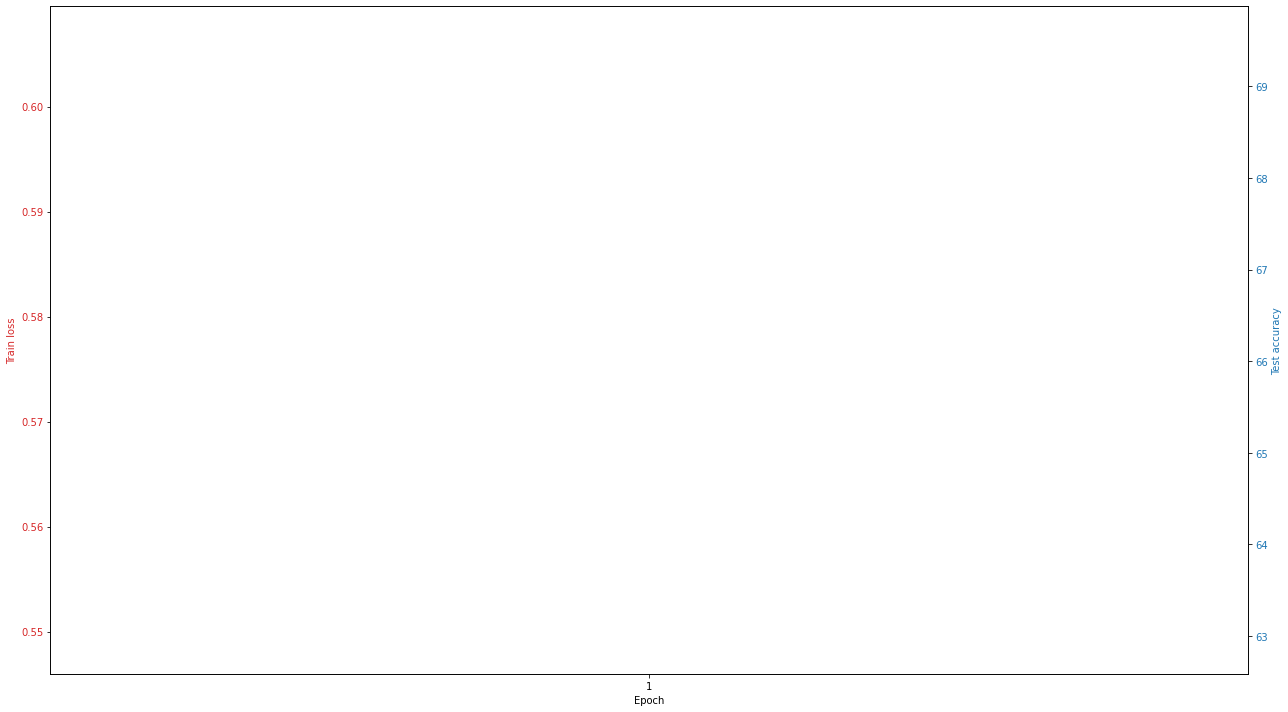

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_1.pth
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.399068
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.373573
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.301226
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.169747
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.290975
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.327168
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.263593
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.313474
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.149197
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.247469

Test set: Average loss: 0.0002, Accuracy: 9490/10000 (95%)

[0.3990682065486908, 0.3144763708114624, 0.3547041416168213, 0.32545801997184753, 0.19393709301948547, 0.2958106994628906, 0.3004121780395508, 0.25404226779937744, 0.3348346948623657, 0.367768257856369, 0.38439056277275085, 0.45853009819984436, 0.4419090151786804, 0.2845217287540436, 0.4694520831108093, 0.36711978912353516, 0.3264540135860443, 0.30414

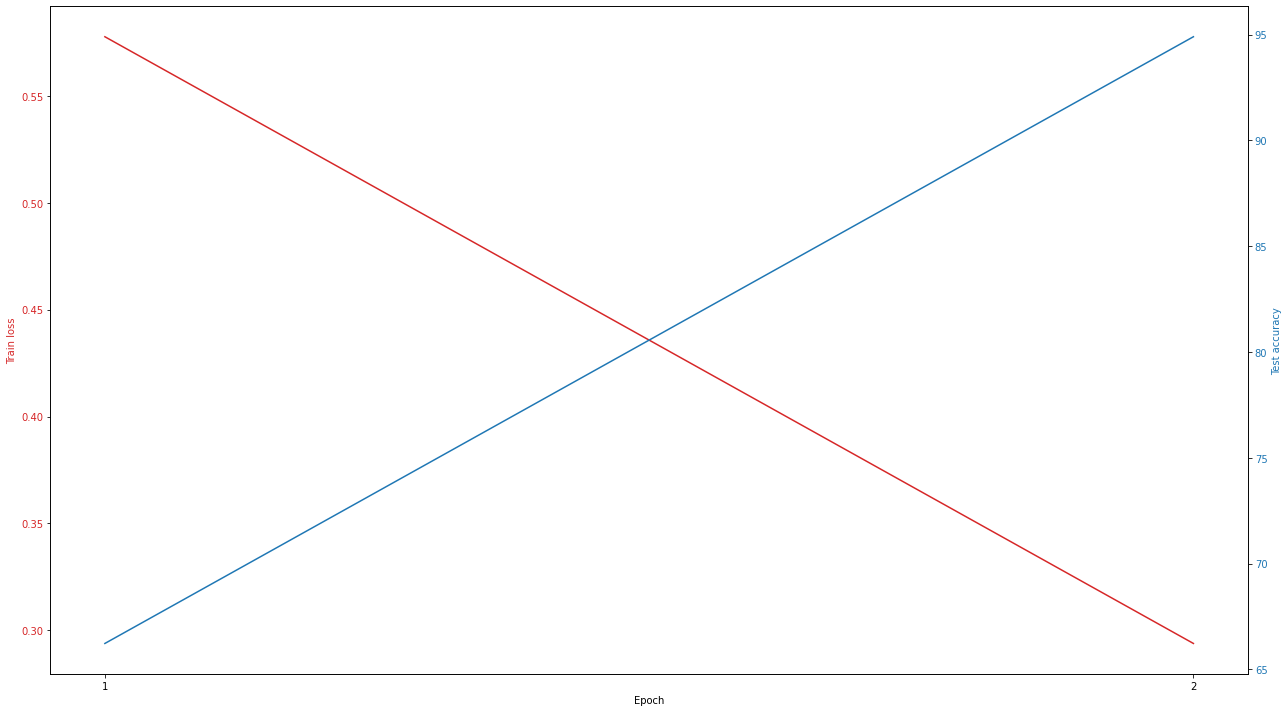

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_2.pth
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.294063
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.192482
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.200348
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.429210
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.192556
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.186911
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.162961
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.315292
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.206495
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.103280

Test set: Average loss: 0.0003, Accuracy: 9107/10000 (91%)

[0.2940630614757538, 0.325304239988327, 0.27084776759147644, 0.27847278118133545, 0.25154194235801697, 0.2917858362197876, 0.10768167674541473, 0.23544864356517792, 0.3328990042209625, 0.13777481019496918, 0.26588156819343567, 0.3495965898036957, 0.17439614236354828, 0.32877132296562195, 0.13657037913799286, 0.21842356026172638, 0.3173937499523163, 0.

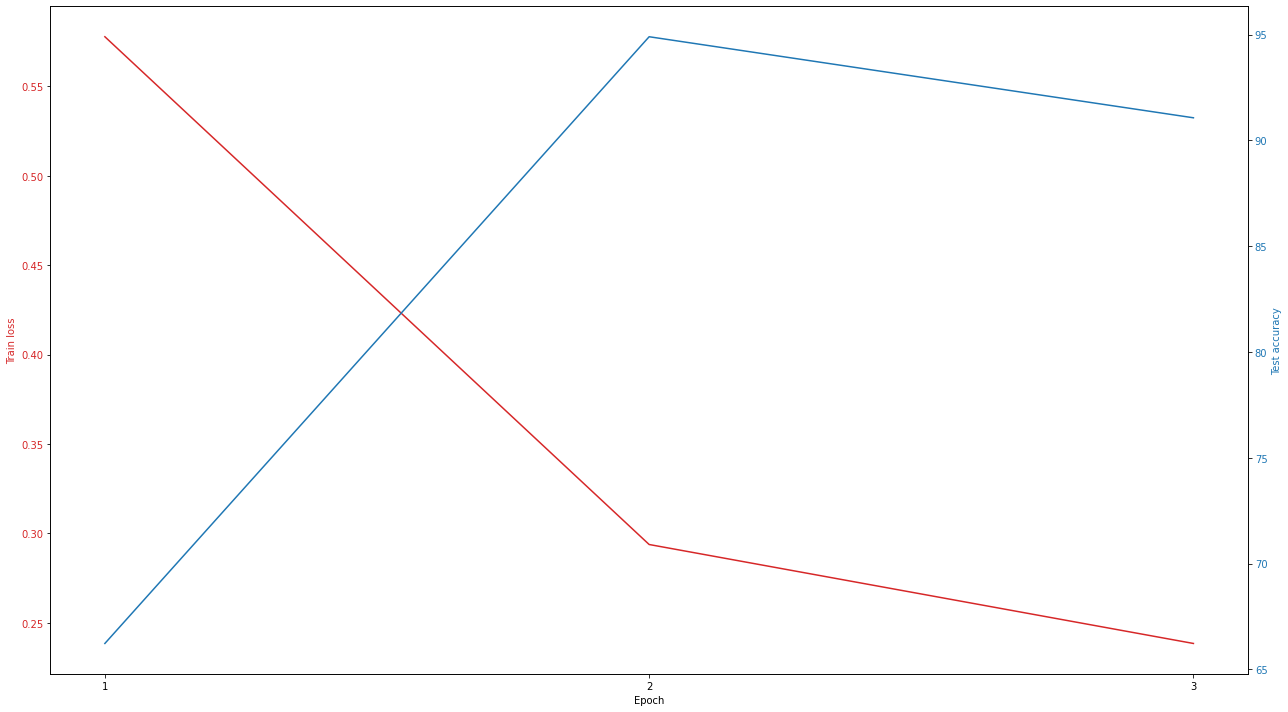

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_3.pth
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.215506
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.272369
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.060932
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.060843
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.241373
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.249573
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.214576
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.205420
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.065119
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.075146

Test set: Average loss: 0.0003, Accuracy: 9241/10000 (92%)

[0.21550606191158295, 0.15927696228027344, 0.1670675426721573, 0.09108603745698929, 0.10982275754213333, 0.15674741566181183, 0.21228043735027313, 0.2004643678665161, 0.1258794069290161, 0.15912222862243652, 0.2534673511981964, 0.22295407950878143, 0.45496666431427, 0.4030269682407379, 0.13387900590896606, 0.1171560138463974, 0.2368645817041397, 0.107

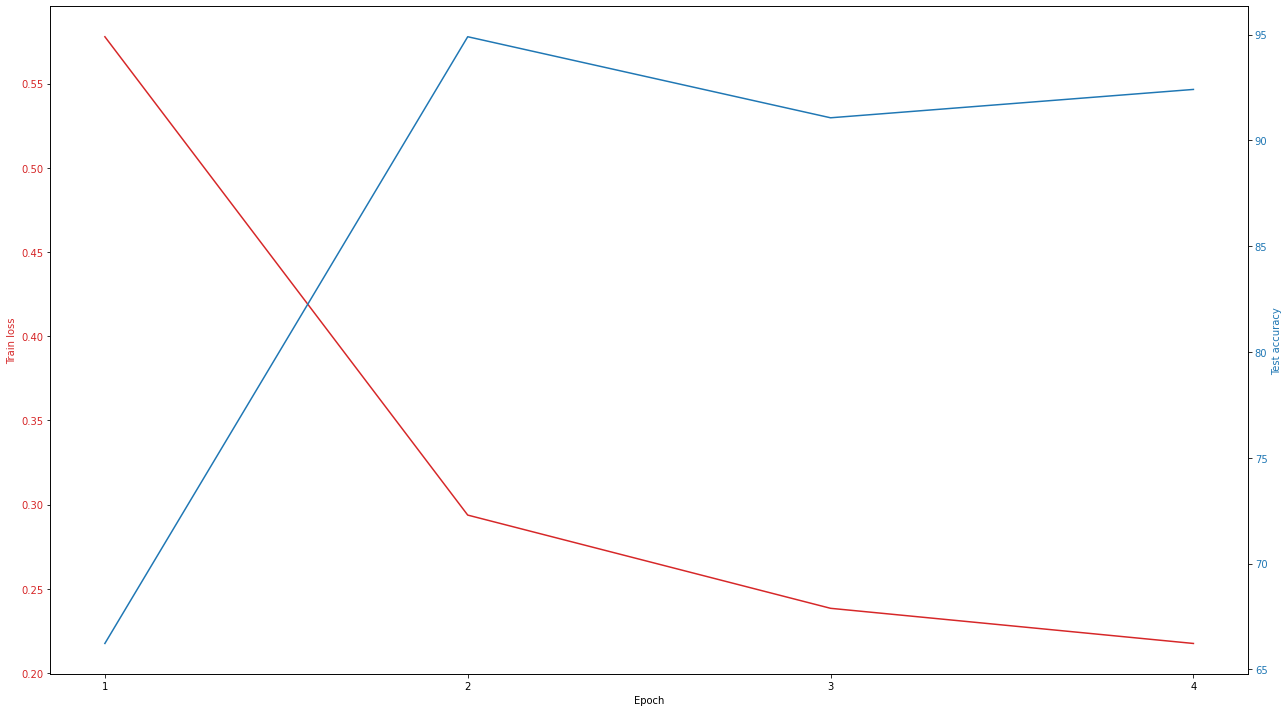

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_4.pth
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.216385
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.235334
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.068630
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.261643
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.127444
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.179226
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.170037
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.233121
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.217023
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.196135

Test set: Average loss: 0.0009, Accuracy: 6755/10000 (68%)

[0.21638473868370056, 0.27388566732406616, 0.275033563375473, 0.2649543285369873, 0.14653708040714264, 0.13237659633159637, 0.1446651667356491, 0.14377577602863312, 0.09376681596040726, 0.12362296134233475, 0.10012362897396088, 0.20768235623836517, 0.20967872440814972, 0.34092074632644653, 0.198750838637352, 0.16051097214221954, 0.19780473411083221, 0

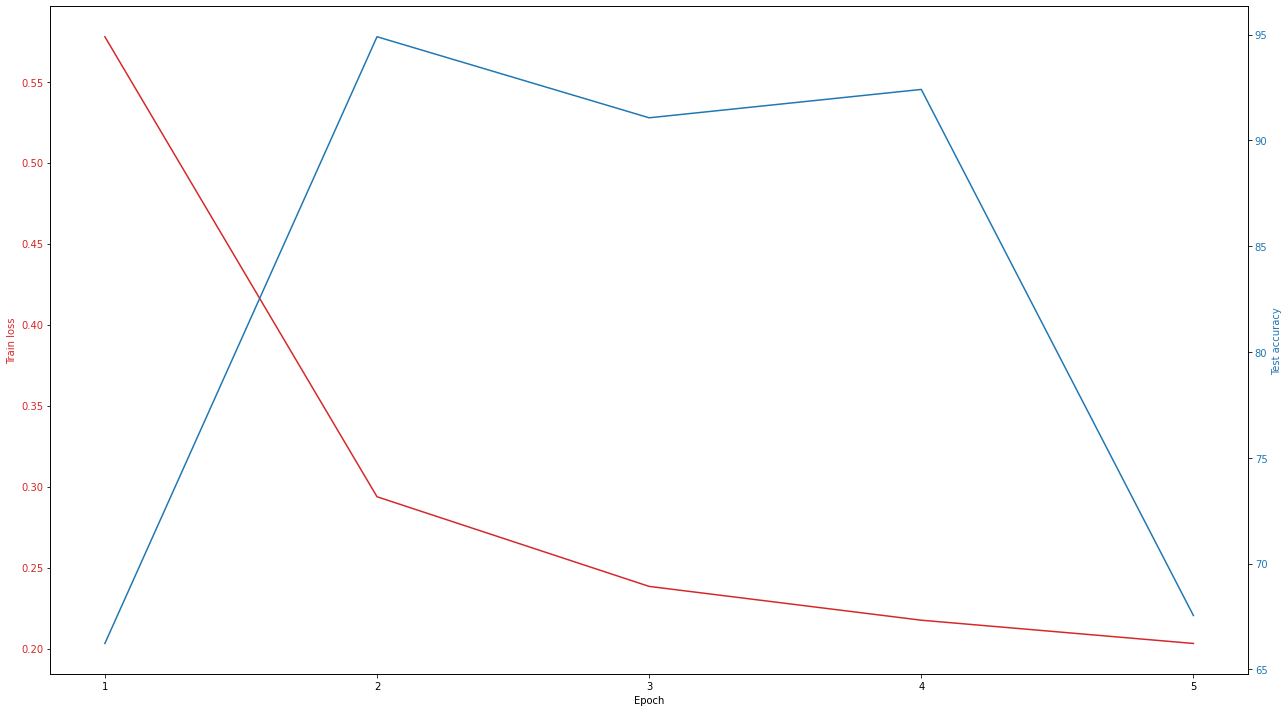

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_5.pth
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.299650
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.072182
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.192613
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.111440
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.140016
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.241086
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.195311
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.179070
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.146416
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.046877

Test set: Average loss: 0.0003, Accuracy: 9137/10000 (91%)

[0.29964950680732727, 0.23661495745182037, 0.42701447010040283, 0.21682322025299072, 0.22929027676582336, 0.10098041594028473, 0.2090032547712326, 0.36107486486434937, 0.1465550810098648, 0.25424230098724365, 0.19102716445922852, 0.19995242357254028, 0.16681446135044098, 0.18328219652175903, 0.19695961475372314, 0.19889651238918304, 0.1610683053731918

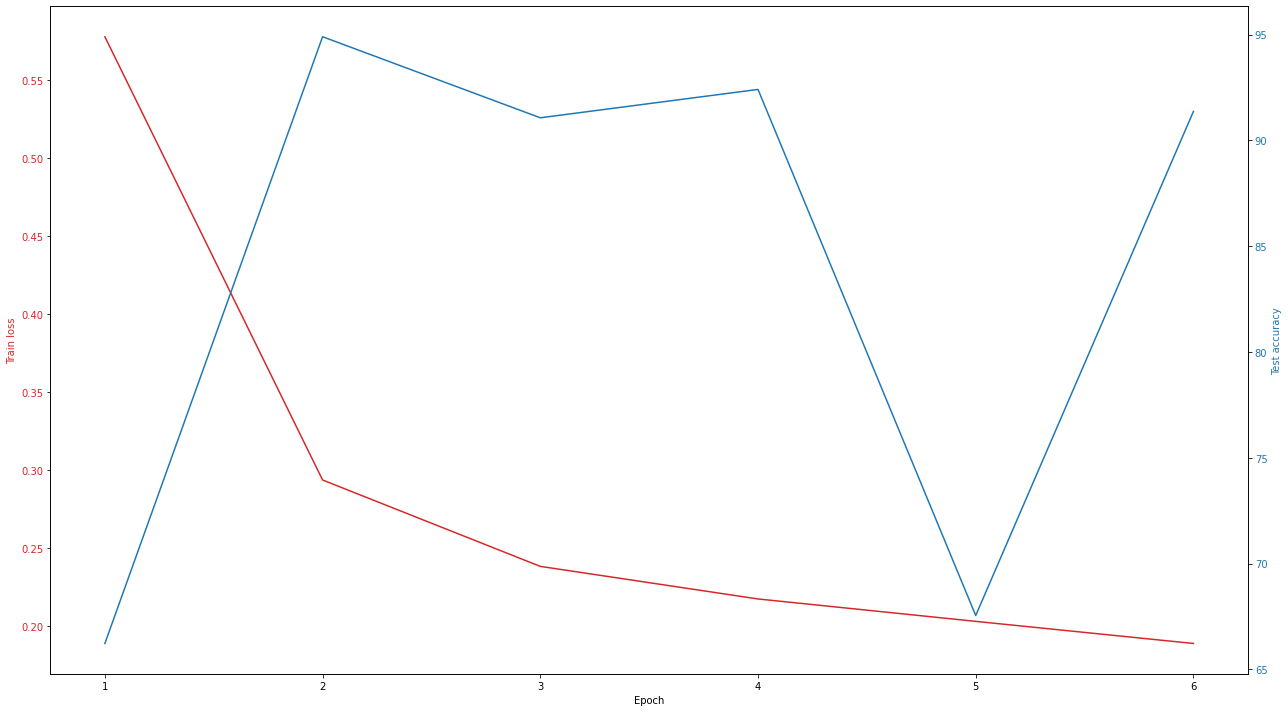

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_6.pth
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.253119
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.144480
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.124508
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.104056
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.258563
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.149896
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.223134
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.184222
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.308132
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.183999

Test set: Average loss: 0.0001, Accuracy: 9629/10000 (96%)

[0.2531188428401947, 0.22517308592796326, 0.09707419574260712, 0.25331830978393555, 0.17186099290847778, 0.16286011040210724, 0.24290378391742706, 0.21406830847263336, 0.08150886744260788, 0.17193618416786194, 0.17362037301063538, 0.2278008759021759, 0.048278700560331345, 0.1802767515182495, 0.09317950159311295, 0.07459834963083267, 0.1864208579063415

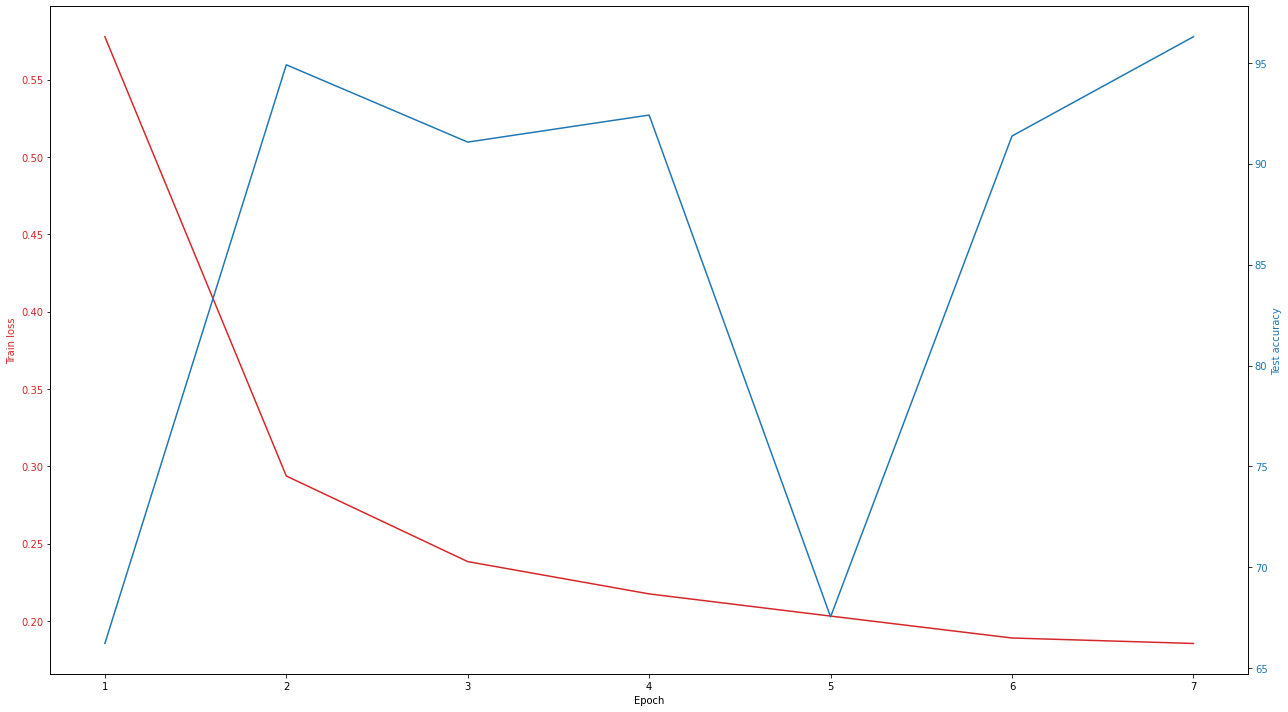

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_7.pth
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.181552
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.128948
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.123822
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.155148
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.226043
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.235643
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.118890
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.288214
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.150848
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.124875

Test set: Average loss: 0.0002, Accuracy: 9551/10000 (96%)

[0.18155215680599213, 0.15698935091495514, 0.23716484010219574, 0.3385755121707916, 0.2039480060338974, 0.12120949476957321, 0.2420705407857895, 0.08831816911697388, 0.30089929699897766, 0.21813450753688812, 0.09824932366609573, 0.2746579647064209, 0.1349373310804367, 0.15841659903526306, 0.3391875922679901, 0.14386767148971558, 0.17795291543006897, 0

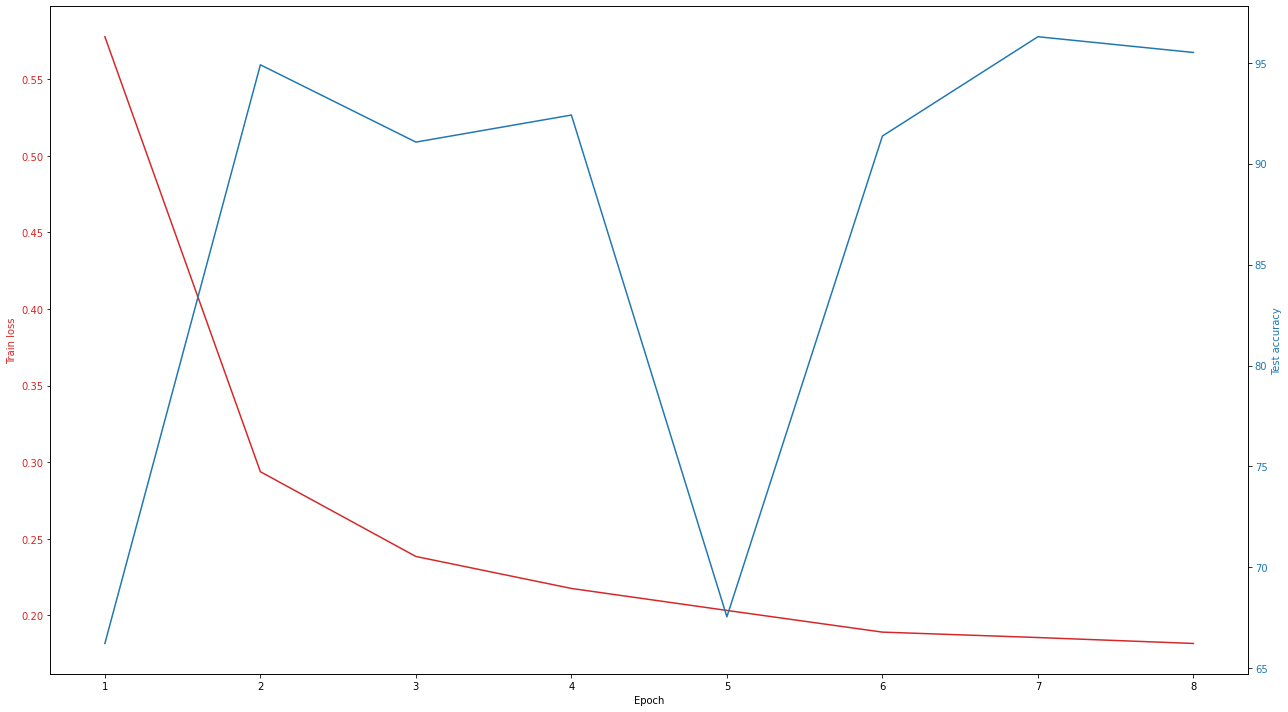

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_8.pth
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.079443
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.060790
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.076750
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.214035
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.232505
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.111775
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.191230
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.346116
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.253483
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.219470

Test set: Average loss: 0.0002, Accuracy: 9501/10000 (95%)

[0.07944326102733612, 0.1446620374917984, 0.11702468991279602, 0.07514600455760956, 0.2074120044708252, 0.08499675989151001, 0.22884836792945862, 0.12244892865419388, 0.11432625353336334, 0.07391660660505295, 0.3099744915962219, 0.07825805991888046, 0.10813969373703003, 0.41989147663116455, 0.1447429060935974, 0.21755965054035187, 0.09698507934808731,

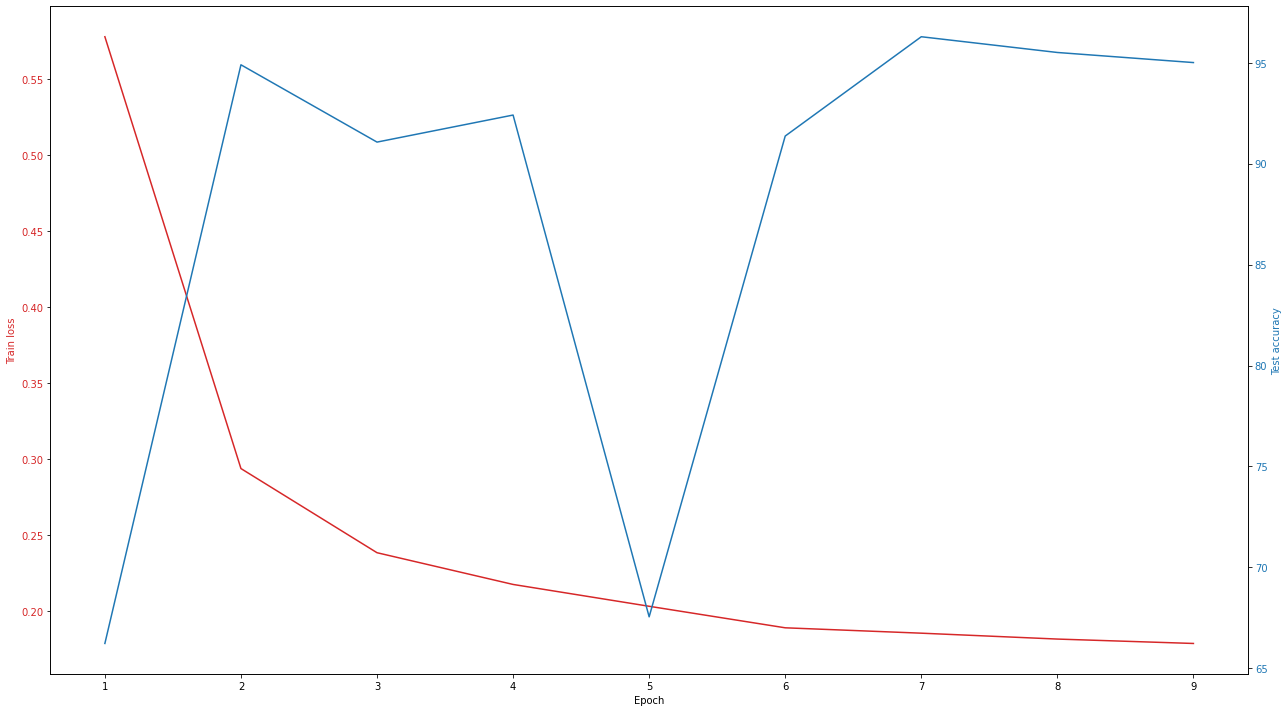

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_9.pth
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.113960
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.157416
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.083422
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.295519
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.149149
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.296235
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.270005
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.089813
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.232218
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.168513

Test set: Average loss: 0.0004, Accuracy: 8597/10000 (86%)

[0.11396022886037827, 0.26706546545028687, 0.13554437458515167, 0.09695442020893097, 0.1269027292728424, 0.10385990142822266, 0.13703425228595734, 0.27853894233703613, 0.02895522117614746, 0.04922235757112503, 0.16229408979415894, 0.15119747817516327, 0.024086255580186844, 0.28673824667930603, 0.1295137256383896, 0.0982125923037529, 0.120649

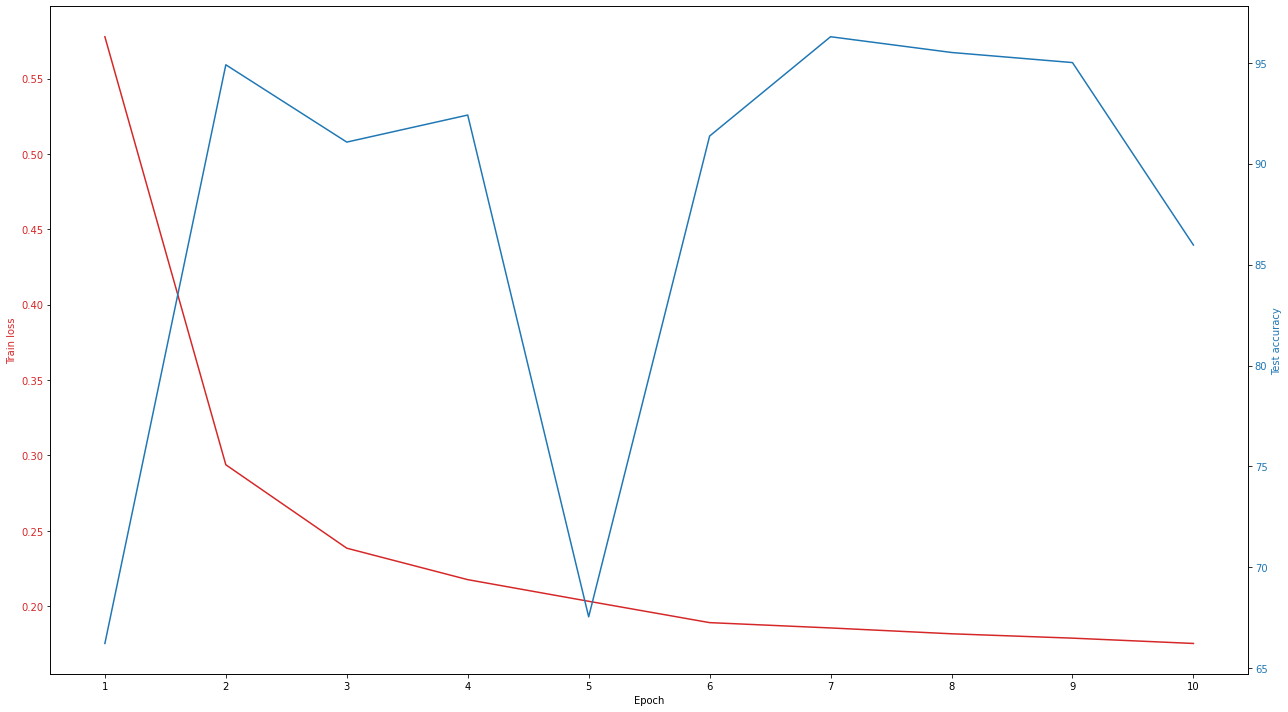

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_10.pth
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.145735
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.084647
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.170470
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.084645
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.119846
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.197922
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.122214
Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.154329
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.051309
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.333435

Test set: Average loss: 0.0002, Accuracy: 9484/10000 (95%)

[0.1457352489233017, 0.23382996022701263, 0.038118891417980194, 0.1552121937274933, 0.1386648416519165, 0.2069922536611557, 0.17120890319347382, 0.25726860761642456, 0.2281840592622757, 0.08280674368143082, 0.35035240650177, 0.20128901302814484, 0.12279824912548065, 0.13042797148227692, 0.09723398089408875, 0.15848812460899353, 0.0907434746

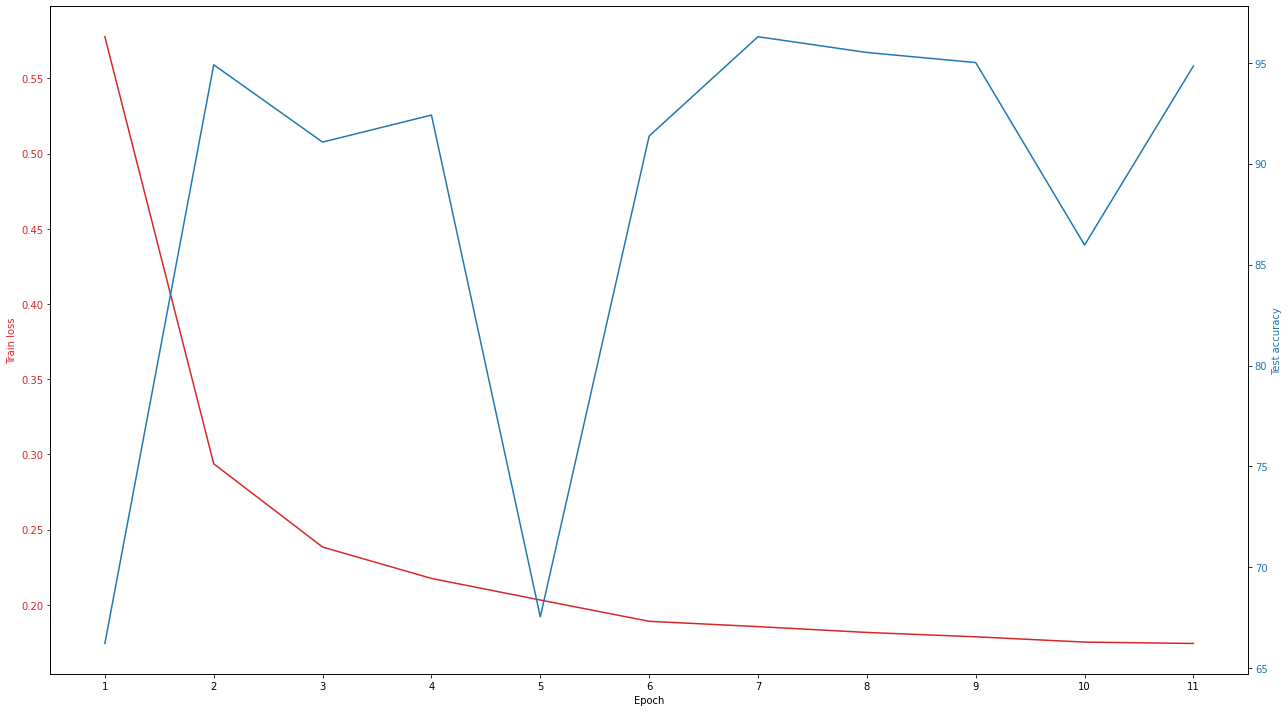

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_11.pth
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.024672
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.296801
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.174677
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.211008
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.063053
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.058106
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.054938
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.067629
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.213434
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.094229

Test set: Average loss: 0.0001, Accuracy: 9648/10000 (96%)

[0.024671504274010658, 0.1404280811548233, 0.09149006009101868, 0.42706868052482605, 0.10688267648220062, 0.18621127307415009, 0.12196305394172668, 0.18945413827896118, 0.2485392987728119, 0.2723432779312134, 0.09545641392469406, 0.08940163999795914, 0.2580075263977051, 0.12558460235595703, 0.2845139503479004, 0.14205549657344818, 0.1046846

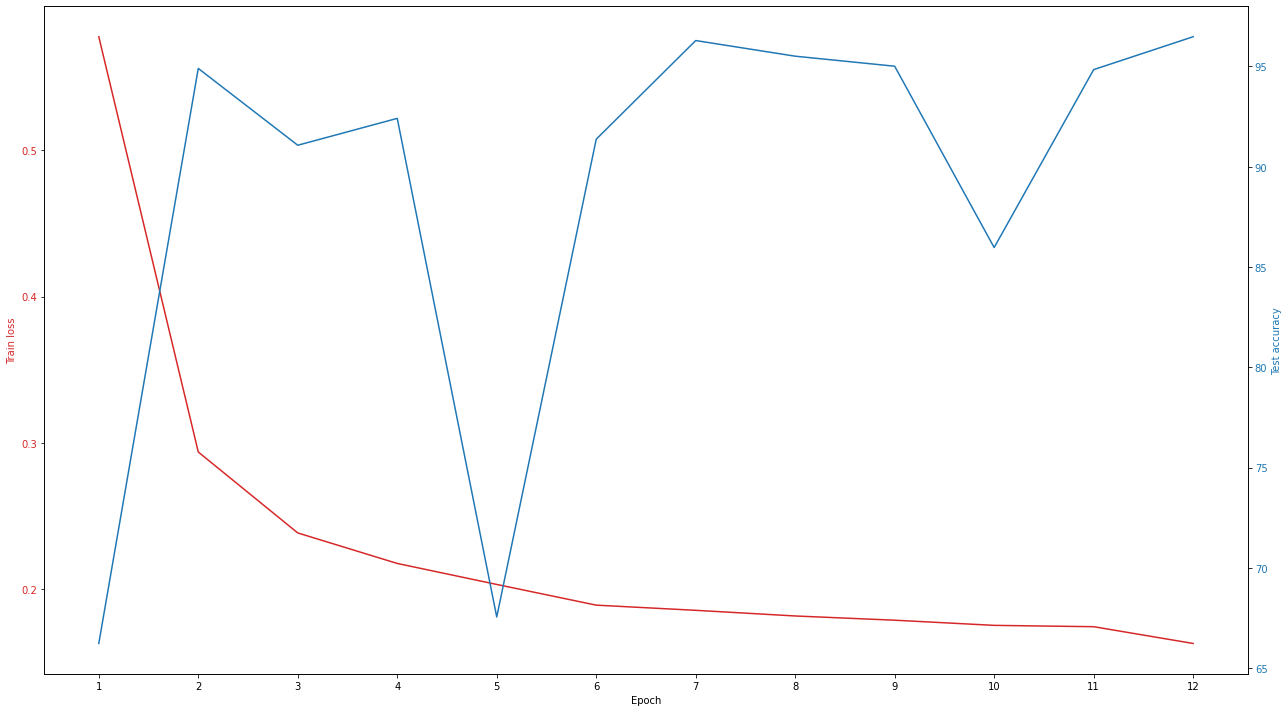

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_12.pth
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.151373
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.082051
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.350013
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.030269
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.194914
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.200261
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.270442
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.164889
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.268371
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.137810

Test set: Average loss: 0.0001, Accuracy: 9627/10000 (96%)

[0.15137343108654022, 0.049820683896541595, 0.1448109745979309, 0.09257855266332626, 0.05131163448095322, 0.22006022930145264, 0.08328603953123093, 0.26656368374824524, 0.16767558455467224, 0.2016790509223938, 0.06385214626789093, 0.17154398560523987, 0.2746642827987671, 0.4275650680065155, 0.37732163071632385, 0.16166594624519348, 0.328104

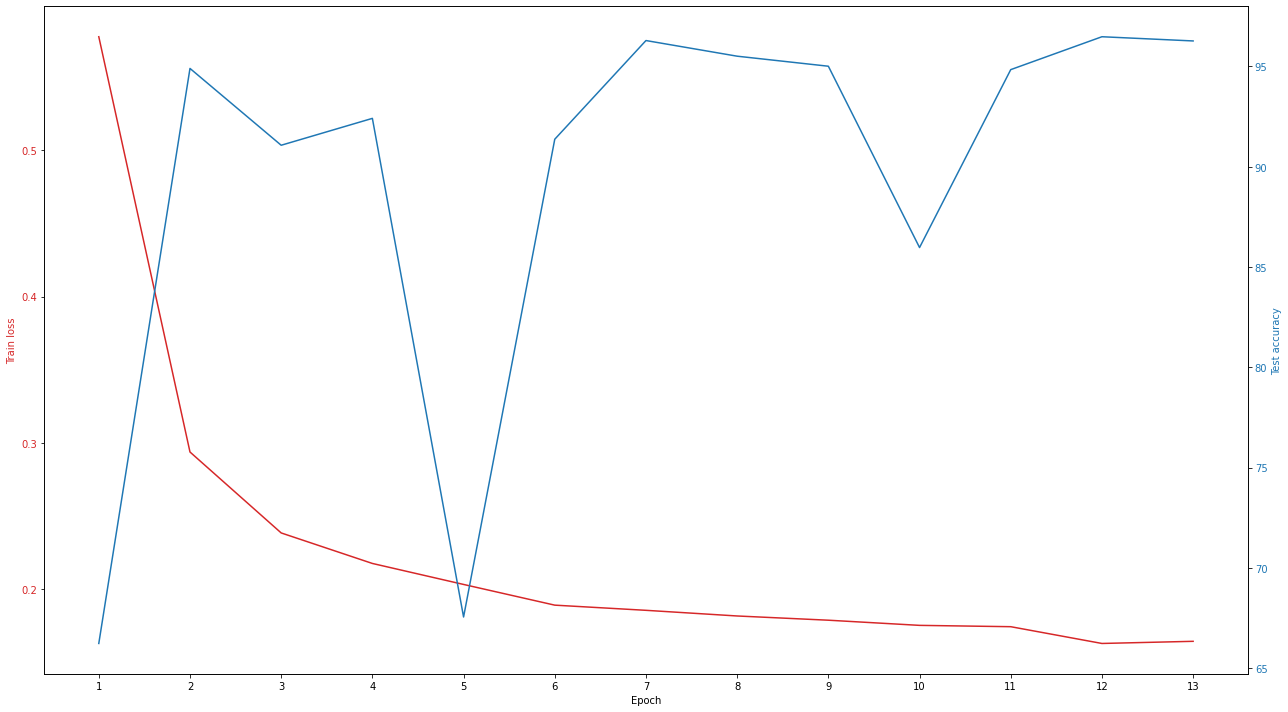

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_13.pth
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.099125
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.255689
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.146715
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.111003
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.093267
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.234398
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.221182
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.093618
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.171730
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.122488

Test set: Average loss: 0.0001, Accuracy: 9604/10000 (96%)

[0.09912455081939697, 0.1053081527352333, 0.08481470495462418, 0.3313690423965454, 0.053230997174978256, 0.28577643632888794, 0.07540055364370346, 0.1939132958650589, 0.15791316330432892, 0.10406078398227692, 0.24476470053195953, 0.19761644303798676, 0.18734210729599, 0.3030829429626465, 0.23905053734779358, 0.04414802044630051, 0.162703901

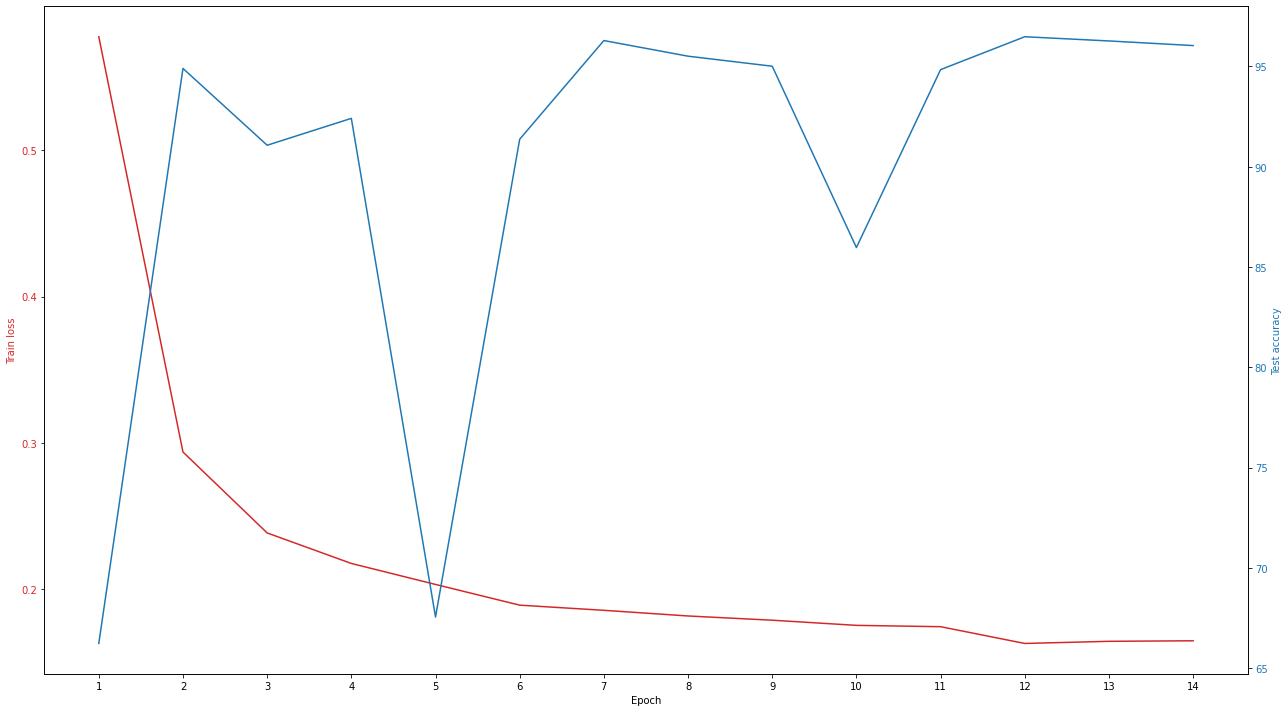

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_14.pth
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.181800
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.096853
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.117284
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.105854
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.104460
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.257076
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.261409
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.199327
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.091110
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.137640

Test set: Average loss: 0.0003, Accuracy: 8911/10000 (89%)

[0.1817997246980667, 0.1843166947364807, 0.10061207413673401, 0.058775532990694046, 0.25367221236228943, 0.14115288853645325, 0.3350931406021118, 0.12316364794969559, 0.09585209935903549, 0.16867035627365112, 0.103524349629879, 0.1875161975622177, 0.09562299400568008, 0.09069032967090607, 0.027007736265659332, 0.10482513159513474, 0.2033074

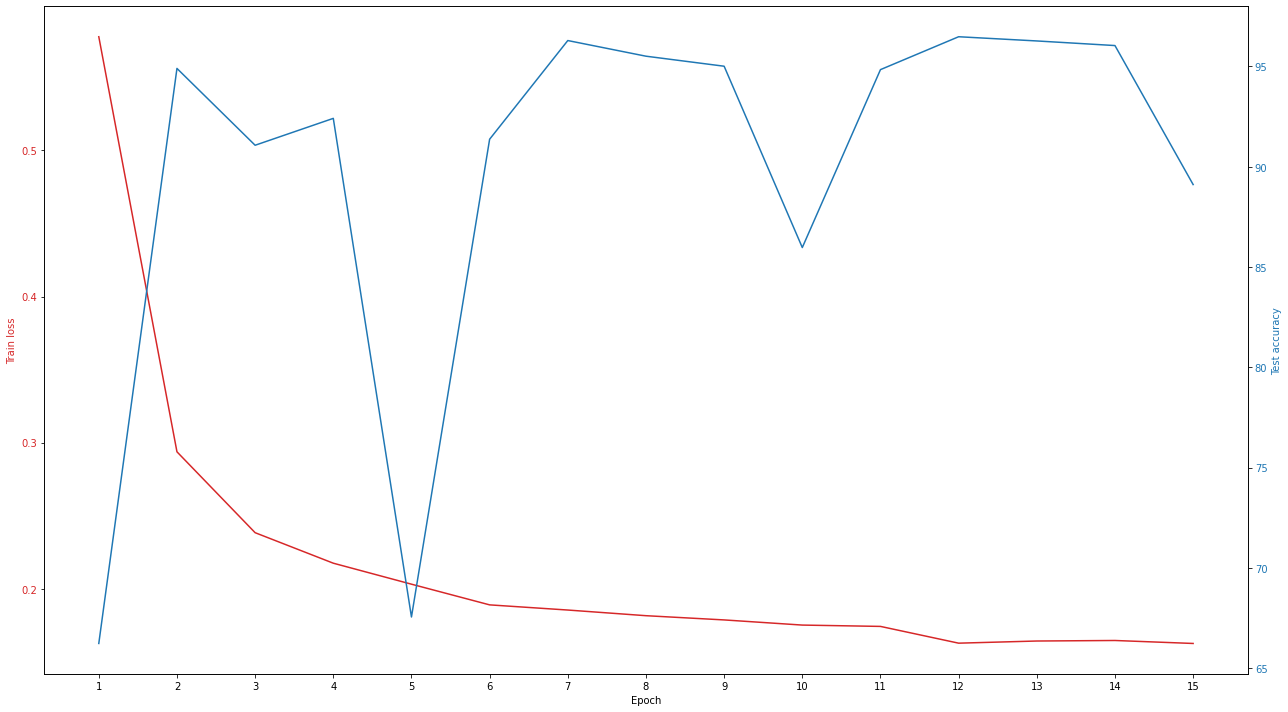

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_15.pth
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.128676
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.087190
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.117983
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.115868
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.302775
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.333051
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.049225
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.187254
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.162870
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.215770

Test set: Average loss: 0.0001, Accuracy: 9627/10000 (96%)

[0.12867586314678192, 0.09565793722867966, 0.07638158649206161, 0.10333211719989777, 0.07258794456720352, 0.11433538049459457, 0.19373482465744019, 0.11808671802282333, 0.11344838887453079, 0.24705974757671356, 0.13597197830677032, 0.03460654616355896, 0.3199140429496765, 0.14242079854011536, 0.10497892647981644, 0.2849367558956146, 0.17110

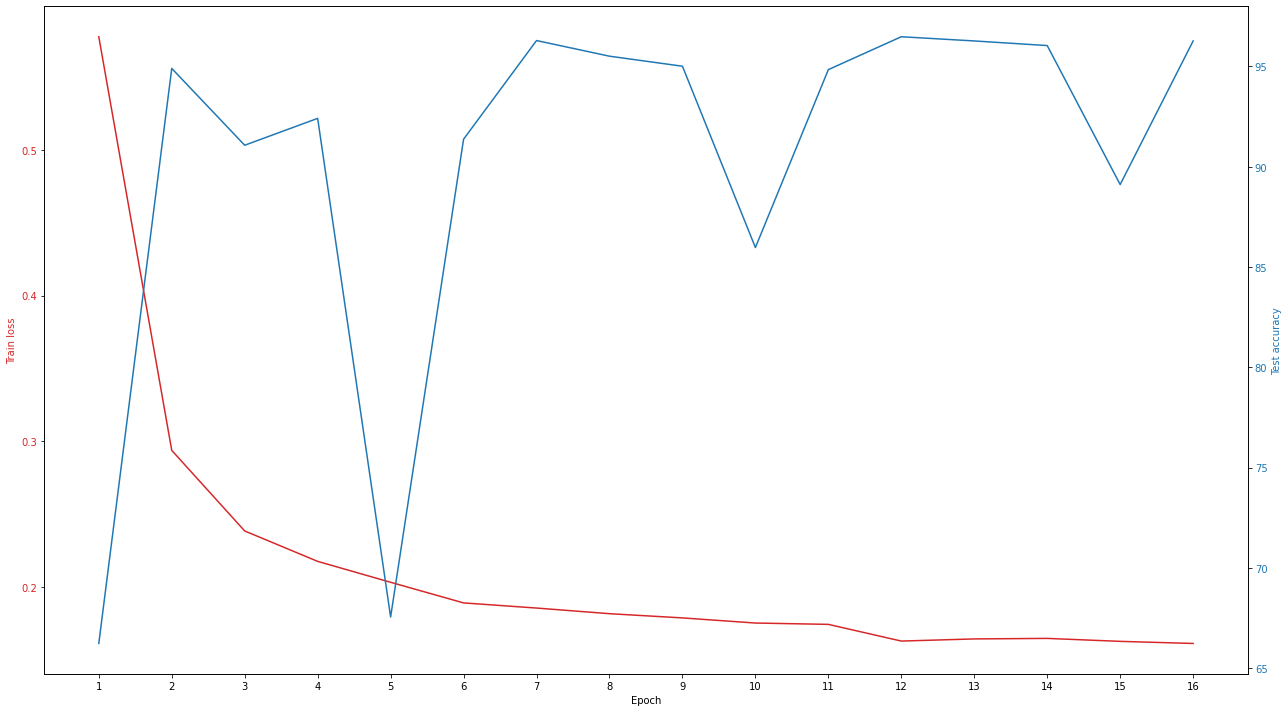

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_16.pth
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.034118
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.187364
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.129331
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.096912
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.169272
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.163242
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.144890
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.149936
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.084742
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.314757

Test set: Average loss: 0.0003, Accuracy: 9042/10000 (90%)

[0.03411770612001419, 0.10090044140815735, 0.07134232670068741, 0.14337553083896637, 0.12669019401073456, 0.22772158682346344, 0.01977800950407982, 0.17236845195293427, 0.23965239524841309, 0.13665984570980072, 0.08132047951221466, 0.11089654266834259, 0.09884495288133621, 0.11211473494768143, 0.09896131604909897, 0.08449774980545044, 0.175

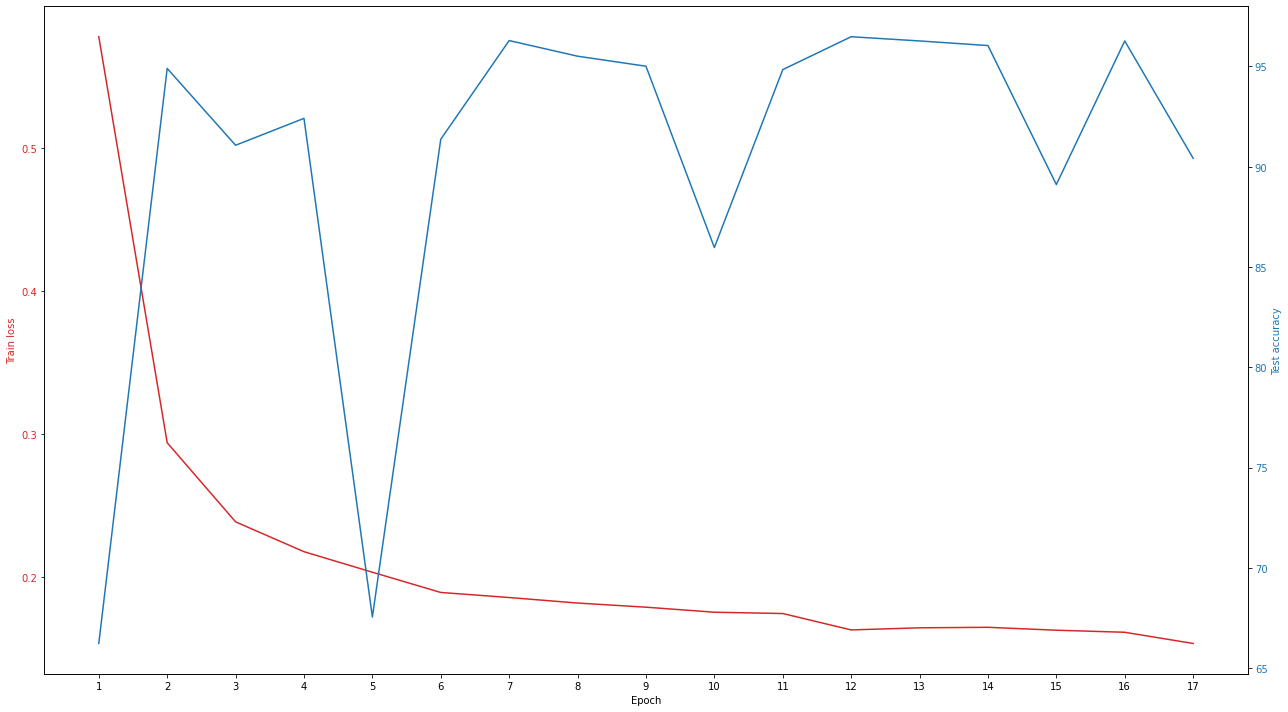

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_17.pth
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.046810
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.250203
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.378966
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.081283
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.083342
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.136736
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.109656
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.064015
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.052768
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.052934

Test set: Average loss: 0.0004, Accuracy: 8627/10000 (86%)

[0.046810414642095566, 0.10923901200294495, 0.2437250316143036, 0.323179692029953, 0.13058532774448395, 0.07148440182209015, 0.14443443715572357, 0.1629198044538498, 0.18839047849178314, 0.1996002197265625, 0.17572133243083954, 0.3598441481590271, 0.17968079447746277, 0.10298992693424225, 0.09288068115711212, 0.16099384427070618, 0.12798056

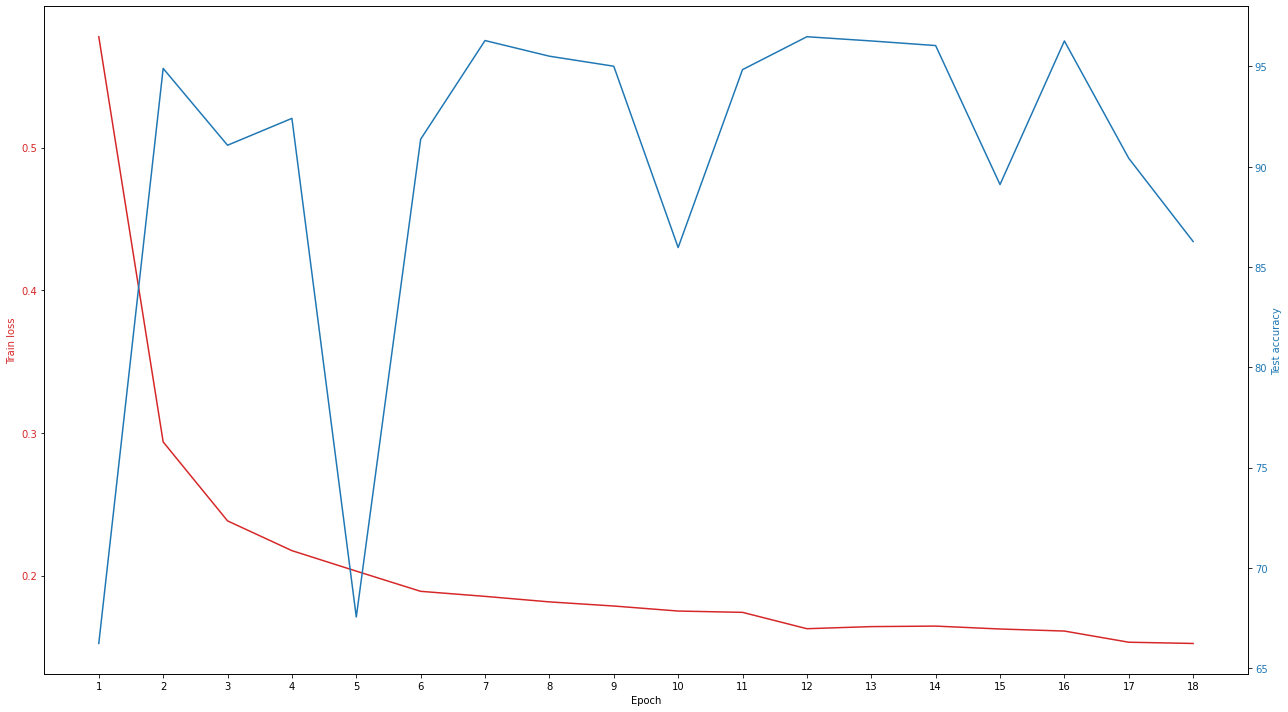

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_18.pth
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.097185
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.036033
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.176980
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.205851
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.157161
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.259417
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.278825
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.121463
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.188837
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.303414

Test set: Average loss: 0.0001, Accuracy: 9597/10000 (96%)

[0.09718537330627441, 0.0944826751947403, 0.14043490588665009, 0.21162544190883636, 0.12921741604804993, 0.1683720350265503, 0.0498775988817215, 0.046357959508895874, 0.08227703720331192, 0.10564298927783966, 0.130613312125206, 0.11078536510467529, 0.07648248970508575, 0.16925081610679626, 0.061954986304044724, 0.07060227543115616, 0.057246

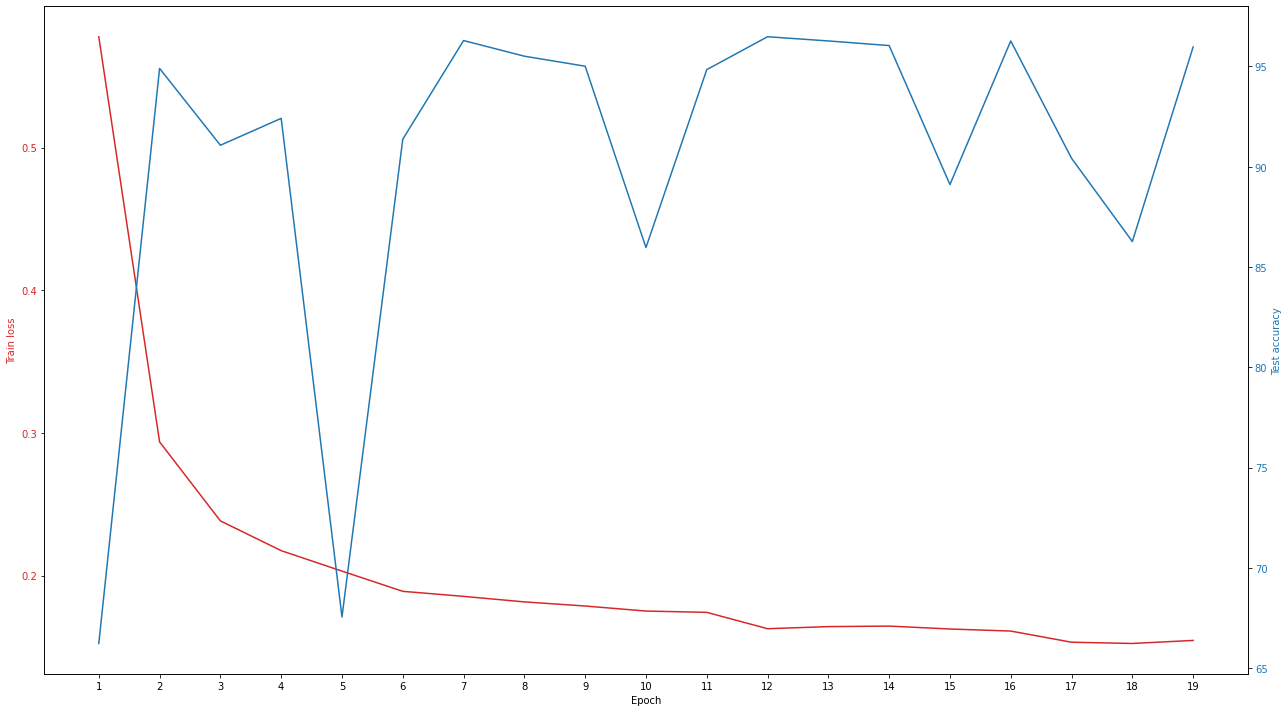

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_19.pth
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.147308
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.099425
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.056809
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.181972
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.076742
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.296572
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.091367
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.145943
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.063727
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.051778

Test set: Average loss: 0.0001, Accuracy: 9661/10000 (97%)

[0.14730842411518097, 0.15744470059871674, 0.17460106313228607, 0.03680356591939926, 0.1388097107410431, 0.05731687322258949, 0.13099750876426697, 0.10633362829685211, 0.10292068868875504, 0.2639758288860321, 0.17592523992061615, 0.14968769252300262, 0.053476445376873016, 0.07401721924543381, 0.2046414464712143, 0.031935397535562515, 0.2265

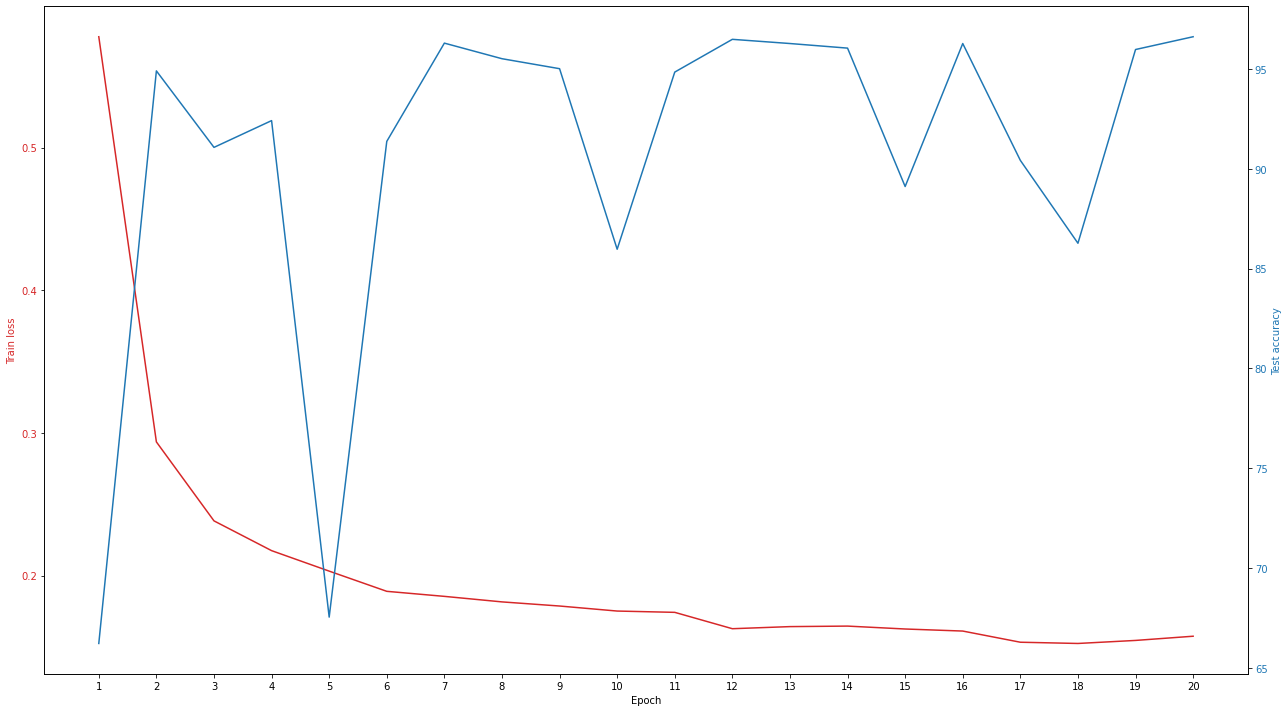

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_20.pth
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.109237
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.285388
Train Epoch: 21 [12800/60000 (21%)]	Loss: 0.070380
Train Epoch: 21 [19200/60000 (32%)]	Loss: 0.088652
Train Epoch: 21 [25600/60000 (43%)]	Loss: 0.127022
Train Epoch: 21 [32000/60000 (53%)]	Loss: 0.129807
Train Epoch: 21 [38400/60000 (64%)]	Loss: 0.367883
Train Epoch: 21 [44800/60000 (75%)]	Loss: 0.209801
Train Epoch: 21 [51200/60000 (85%)]	Loss: 0.122441
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.188664

Test set: Average loss: 0.0002, Accuracy: 9547/10000 (95%)

[0.10923672467470169, 0.15423047542572021, 0.24933487176895142, 0.24940225481987, 0.09802062809467316, 0.11556869000196457, 0.06253422051668167, 0.16948072612285614, 0.11767883598804474, 0.1673385500907898, 0.08883306384086609, 0.13415062427520752, 0.08208714425563812, 0.1941218376159668, 0.12703222036361694, 0.11568573862314224, 0.26901882

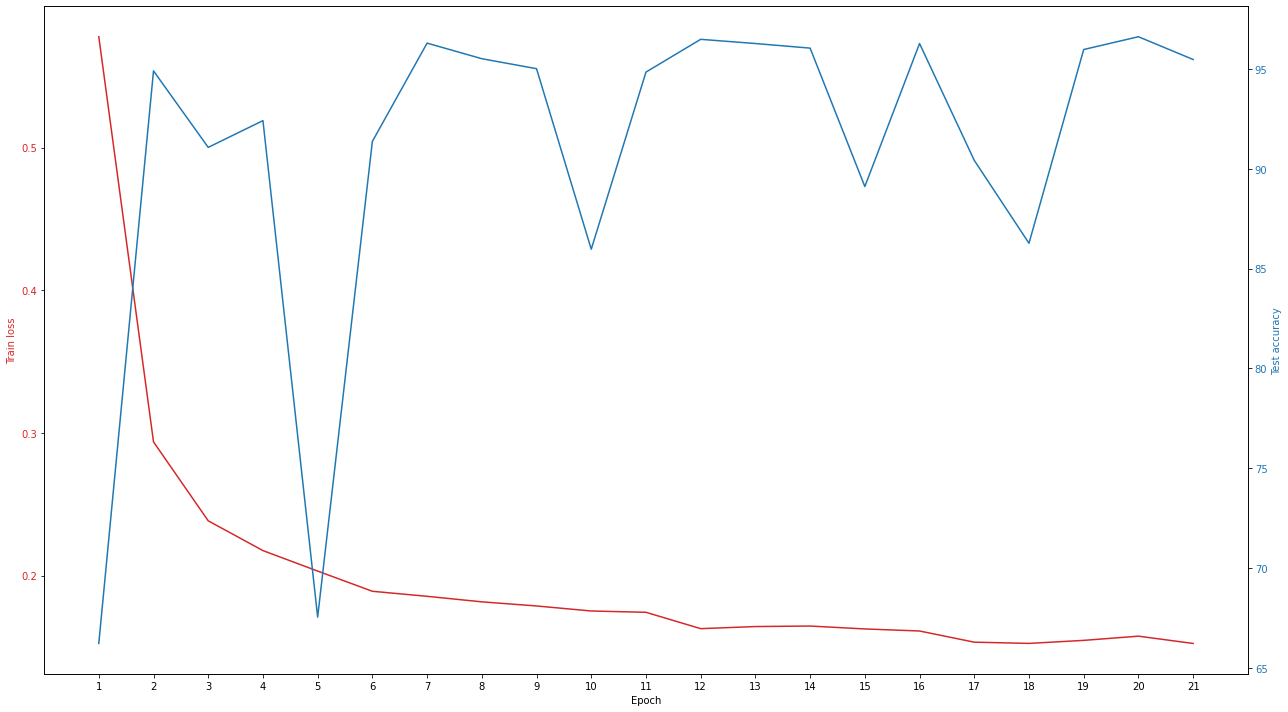

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_21.pth
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.181423
Train Epoch: 22 [6400/60000 (11%)]	Loss: 0.167038
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.158299
Train Epoch: 22 [19200/60000 (32%)]	Loss: 0.159663
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.164336
Train Epoch: 22 [32000/60000 (53%)]	Loss: 0.063130
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.165269
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.148860
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.374721
Train Epoch: 22 [57600/60000 (96%)]	Loss: 0.108759

Test set: Average loss: 0.0005, Accuracy: 8447/10000 (84%)

[0.18142257630825043, 0.12391752749681473, 0.15886977314949036, 0.1280556321144104, 0.1608920395374298, 0.07694652676582336, 0.06669902801513672, 0.1491185575723648, 0.2377617061138153, 0.1636703908443451, 0.12468548119068146, 0.17347003519535065, 0.22411386668682098, 0.14989091455936432, 0.1490069031715393, 0.10463972389698029, 0.097086019

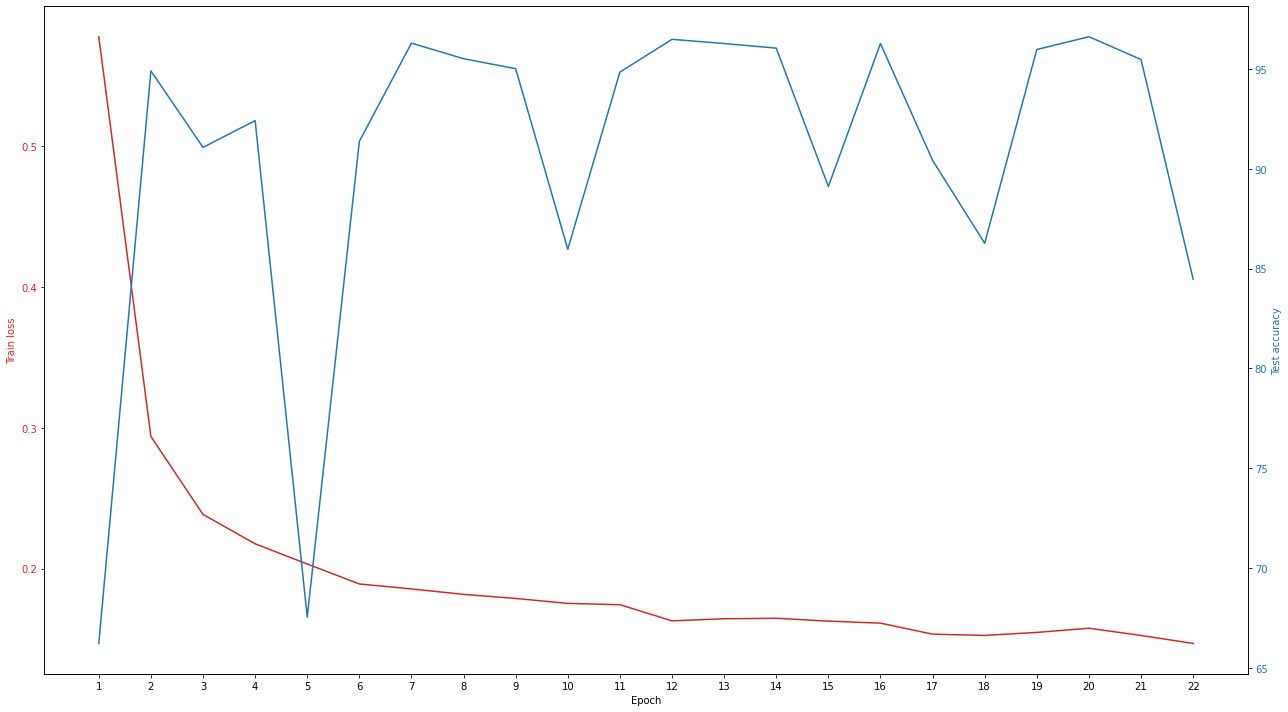

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_22.pth
Train Epoch: 23 [0/60000 (0%)]	Loss: 0.194591
Train Epoch: 23 [6400/60000 (11%)]	Loss: 0.232945
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.104415
Train Epoch: 23 [19200/60000 (32%)]	Loss: 0.054346
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.099044
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.187364
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.116170
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.123375
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.160972
Train Epoch: 23 [57600/60000 (96%)]	Loss: 0.105042

Test set: Average loss: 0.0003, Accuracy: 8996/10000 (90%)

[0.1945907175540924, 0.18236057460308075, 0.09668046236038208, 0.05804525315761566, 0.221003919839859, 0.10527991503477097, 0.14490094780921936, 0.233720064163208, 0.3519662618637085, 0.13838805258274078, 0.2653726041316986, 0.09968598932027817, 0.12075142562389374, 0.05545517057180405, 0.23701952397823334, 0.1064239889383316, 0.09475805610

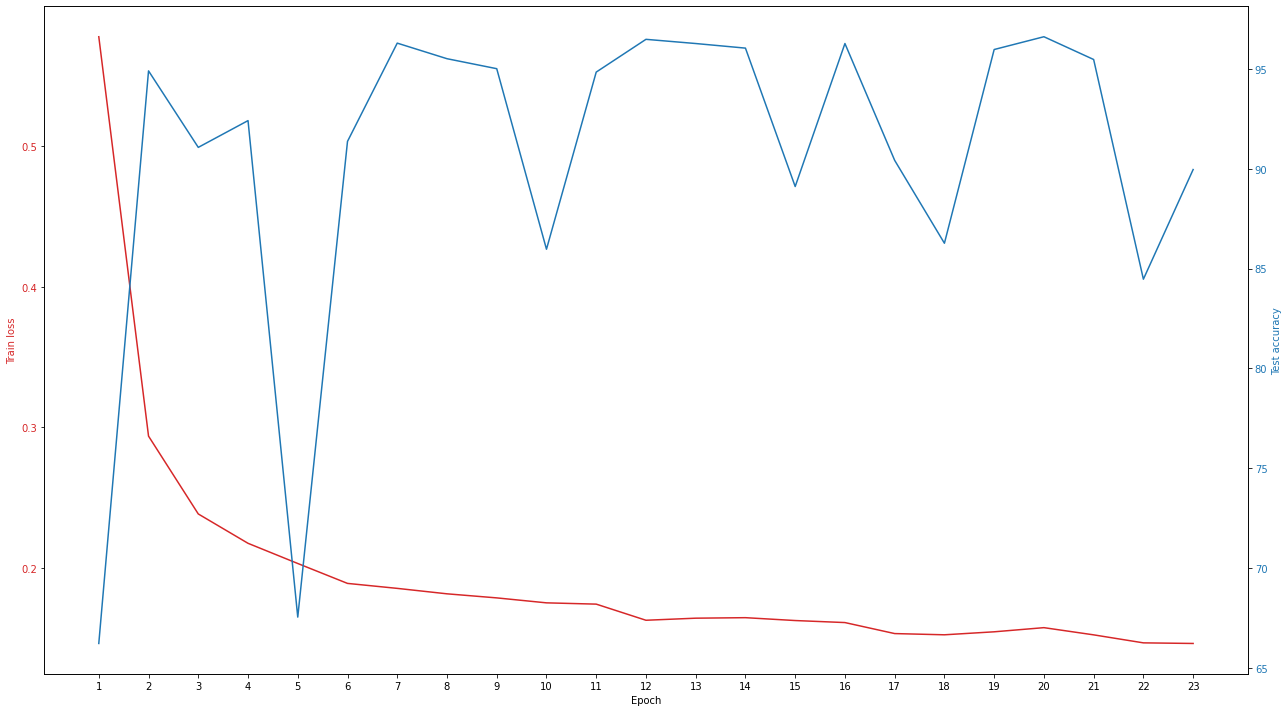

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_23.pth
Train Epoch: 24 [0/60000 (0%)]	Loss: 0.060228
Train Epoch: 24 [6400/60000 (11%)]	Loss: 0.106333
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.108596
Train Epoch: 24 [19200/60000 (32%)]	Loss: 0.062381
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.190155
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.313056
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.052448
Train Epoch: 24 [44800/60000 (75%)]	Loss: 0.092462
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.038063
Train Epoch: 24 [57600/60000 (96%)]	Loss: 0.121011

Test set: Average loss: 0.0001, Accuracy: 9679/10000 (97%)

[0.06022780388593674, 0.1955341100692749, 0.33325260877609253, 0.06855888664722443, 0.10528133809566498, 0.05285593122243881, 0.3175847828388214, 0.1563427448272705, 0.06712516397237778, 0.08534073829650879, 0.10804761201143265, 0.15430249273777008, 0.05413253232836723, 0.26806068420410156, 0.08529121428728104, 0.20708496868610382, 0.063905

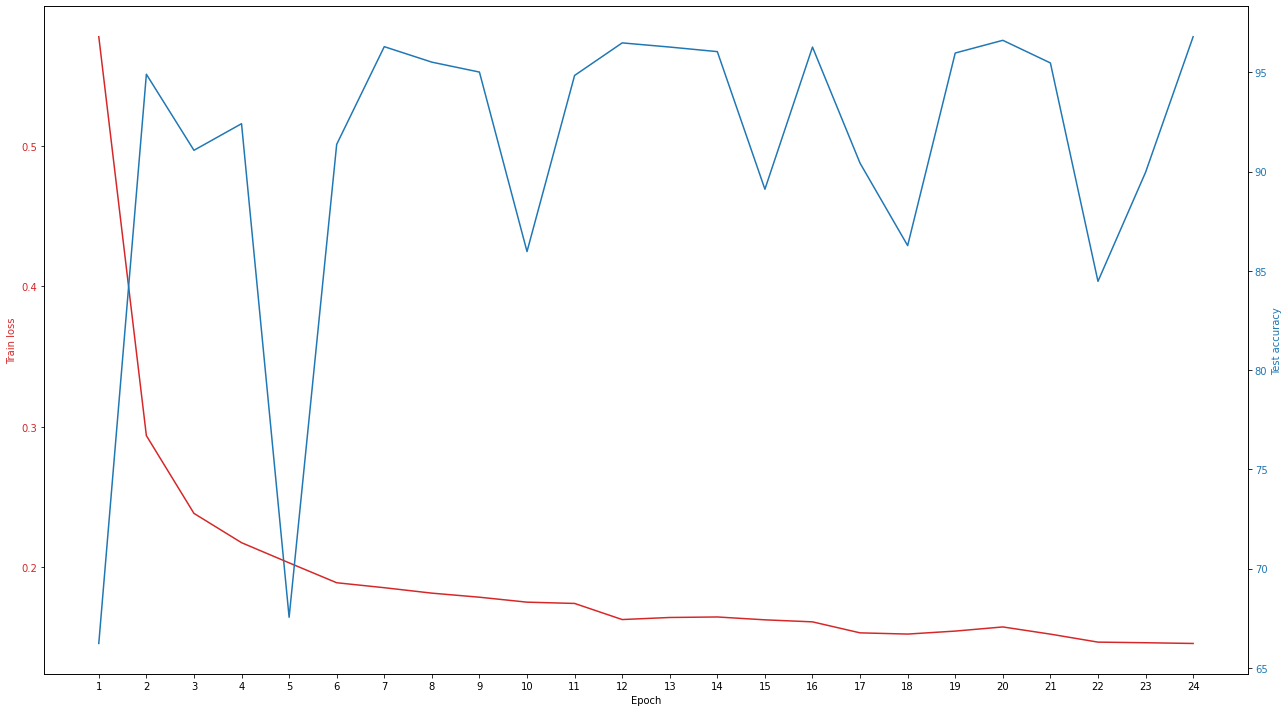

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_24.pth
Train Epoch: 25 [0/60000 (0%)]	Loss: 0.041482
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.383625
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.143358
Train Epoch: 25 [19200/60000 (32%)]	Loss: 0.243821
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.108510
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.090250
Train Epoch: 25 [38400/60000 (64%)]	Loss: 0.133539
Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.230451
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.259678
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.204632

Test set: Average loss: 0.0003, Accuracy: 9225/10000 (92%)

[0.04148239269852638, 0.36567187309265137, 0.31877803802490234, 0.11900193989276886, 0.05913710966706276, 0.13010823726654053, 0.038287028670310974, 0.20538045465946198, 0.0743168443441391, 0.1565055102109909, 0.27833765745162964, 0.08036863058805466, 0.2326805740594864, 0.06173896789550781, 0.3509592115879059, 0.14872246980667114, 0.124174

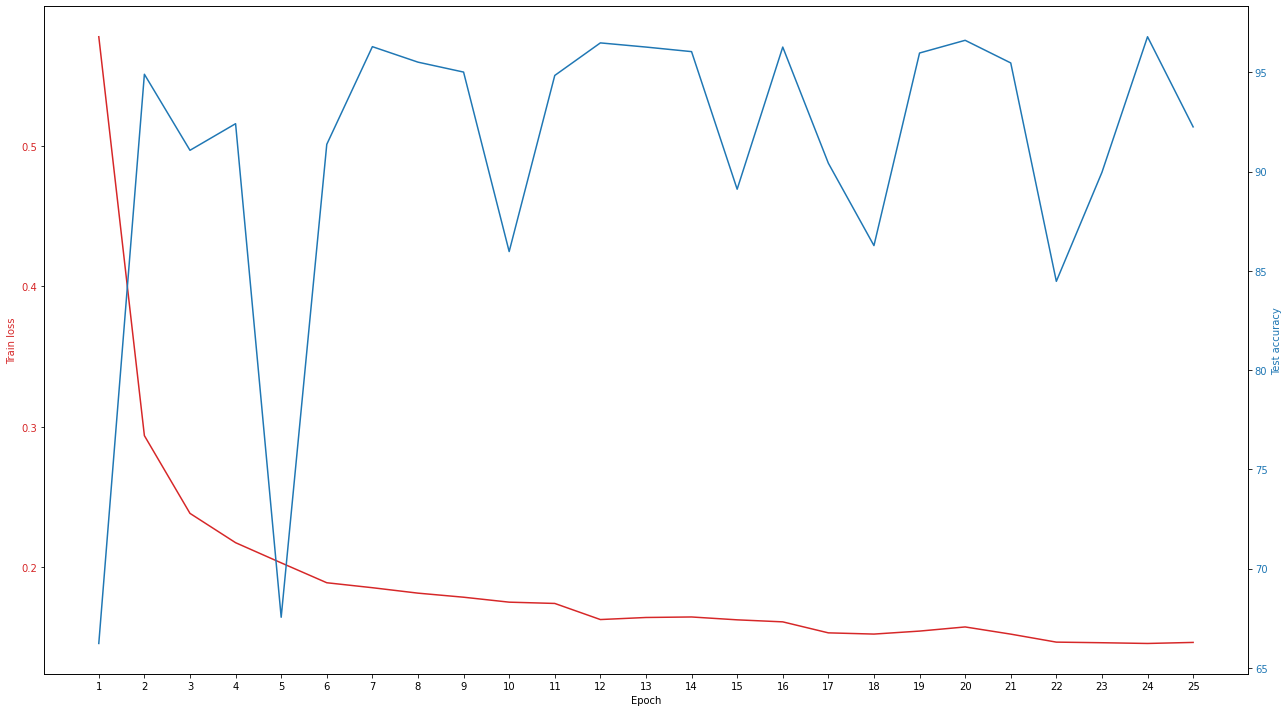

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_25.pth
Train Epoch: 26 [0/60000 (0%)]	Loss: 0.128547
Train Epoch: 26 [6400/60000 (11%)]	Loss: 0.104508
Train Epoch: 26 [12800/60000 (21%)]	Loss: 0.180694
Train Epoch: 26 [19200/60000 (32%)]	Loss: 0.056679
Train Epoch: 26 [25600/60000 (43%)]	Loss: 0.089708
Train Epoch: 26 [32000/60000 (53%)]	Loss: 0.121964
Train Epoch: 26 [38400/60000 (64%)]	Loss: 0.151587
Train Epoch: 26 [44800/60000 (75%)]	Loss: 0.187908
Train Epoch: 26 [51200/60000 (85%)]	Loss: 0.037130
Train Epoch: 26 [57600/60000 (96%)]	Loss: 0.090842

Test set: Average loss: 0.0001, Accuracy: 9591/10000 (96%)

[0.12854734063148499, 0.19646470248699188, 0.14396926760673523, 0.08724179118871689, 0.11340416222810745, 0.12165017426013947, 0.04971988499164581, 0.1591901183128357, 0.10200627148151398, 0.18394674360752106, 0.15071243047714233, 0.3711845576763153, 0.18457026779651642, 0.03635597229003906, 0.3980233669281006, 0.13447146117687225, 0.187179

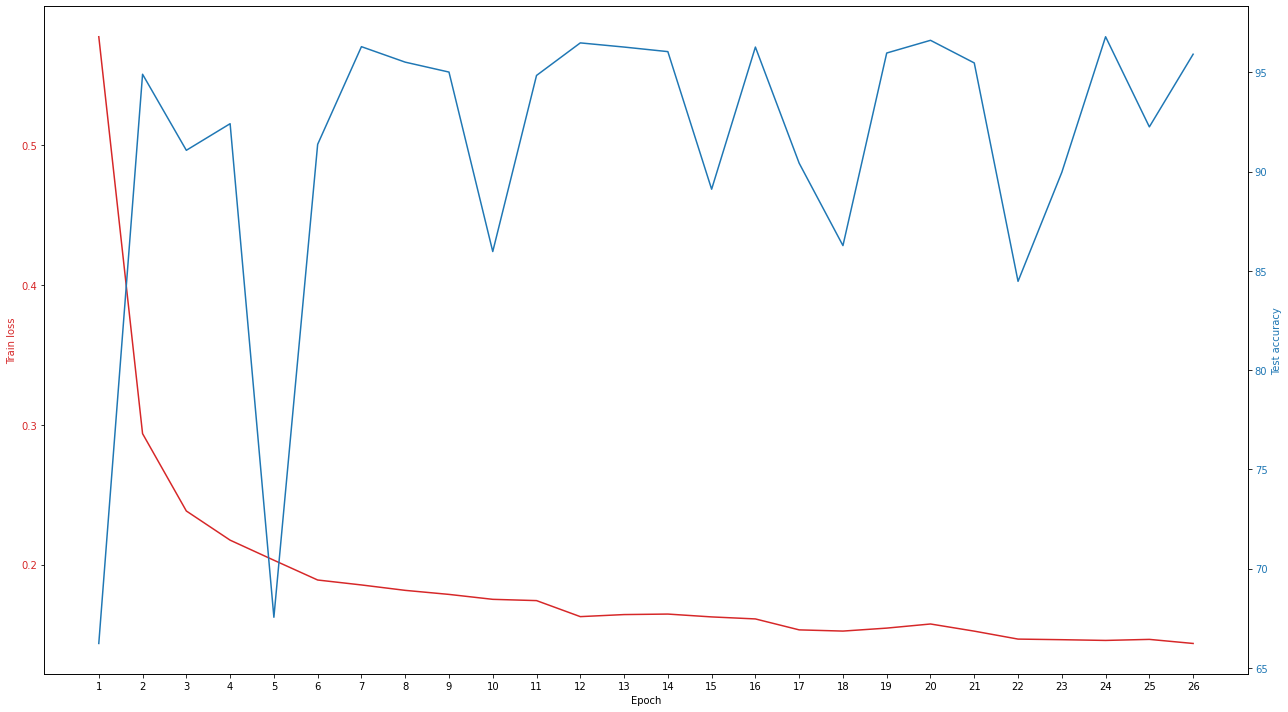

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_26.pth
Train Epoch: 27 [0/60000 (0%)]	Loss: 0.097411
Train Epoch: 27 [6400/60000 (11%)]	Loss: 0.168076
Train Epoch: 27 [12800/60000 (21%)]	Loss: 0.079684
Train Epoch: 27 [19200/60000 (32%)]	Loss: 0.109283
Train Epoch: 27 [25600/60000 (43%)]	Loss: 0.217010
Train Epoch: 27 [32000/60000 (53%)]	Loss: 0.133594
Train Epoch: 27 [38400/60000 (64%)]	Loss: 0.174281
Train Epoch: 27 [44800/60000 (75%)]	Loss: 0.105085
Train Epoch: 27 [51200/60000 (85%)]	Loss: 0.312467
Train Epoch: 27 [57600/60000 (96%)]	Loss: 0.139232

Test set: Average loss: 0.0001, Accuracy: 9576/10000 (96%)

[0.09741109609603882, 0.14090852439403534, 0.1259860247373581, 0.16528713703155518, 0.18756937980651855, 0.21483080089092255, 0.08679529279470444, 0.11870009452104568, 0.11055964976549149, 0.05544353276491165, 0.27892211079597473, 0.22987321019172668, 0.10128109902143478, 0.2855670154094696, 0.4475069046020508, 0.07603523135185242, 0.136641

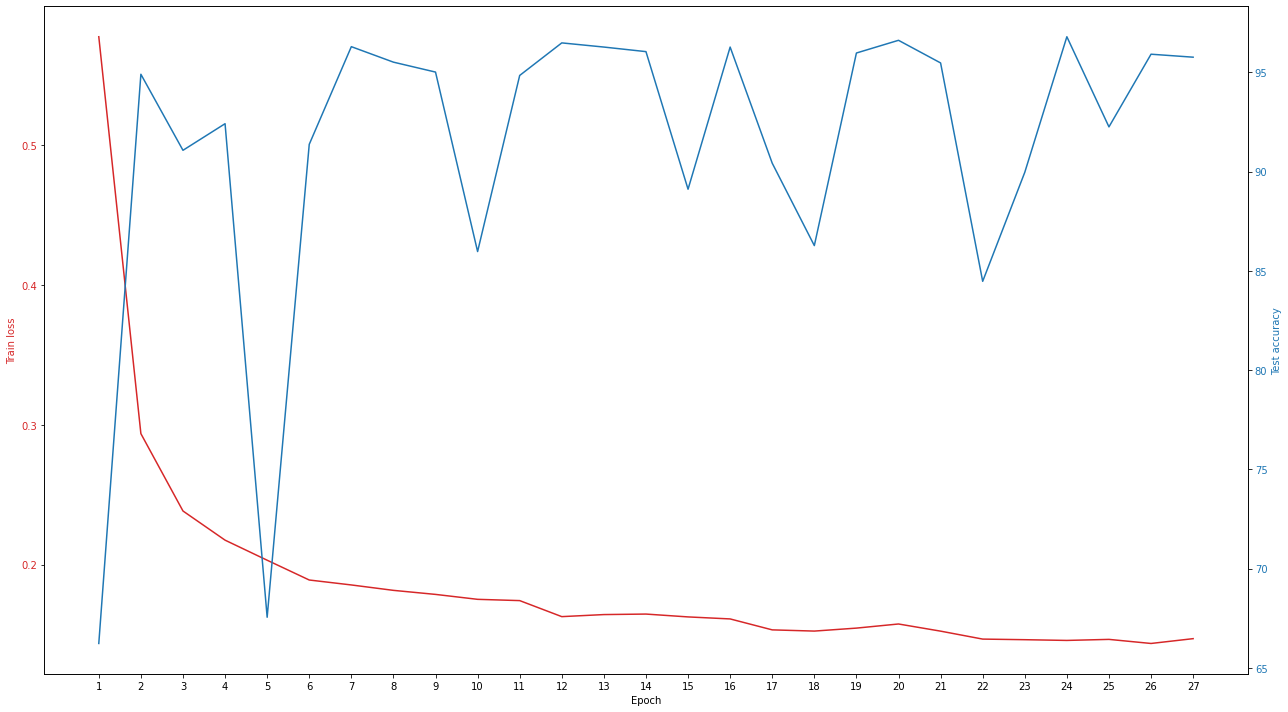

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_27.pth
Train Epoch: 28 [0/60000 (0%)]	Loss: 0.072366
Train Epoch: 28 [6400/60000 (11%)]	Loss: 0.190017
Train Epoch: 28 [12800/60000 (21%)]	Loss: 0.138750
Train Epoch: 28 [19200/60000 (32%)]	Loss: 0.156486
Train Epoch: 28 [25600/60000 (43%)]	Loss: 0.044785
Train Epoch: 28 [32000/60000 (53%)]	Loss: 0.075363
Train Epoch: 28 [38400/60000 (64%)]	Loss: 0.238109
Train Epoch: 28 [44800/60000 (75%)]	Loss: 0.039266
Train Epoch: 28 [51200/60000 (85%)]	Loss: 0.099333
Train Epoch: 28 [57600/60000 (96%)]	Loss: 0.077790

Test set: Average loss: 0.0005, Accuracy: 8675/10000 (87%)

[0.07236622273921967, 0.1544324904680252, 0.06405966728925705, 0.13507947325706482, 0.06002410501241684, 0.23875084519386292, 0.06582704931497574, 0.05429620295763016, 0.16239702701568604, 0.03388337045907974, 0.24212436378002167, 0.14068521559238434, 0.21026188135147095, 0.028504028916358948, 0.10551939159631729, 0.06015196442604065, 0.044

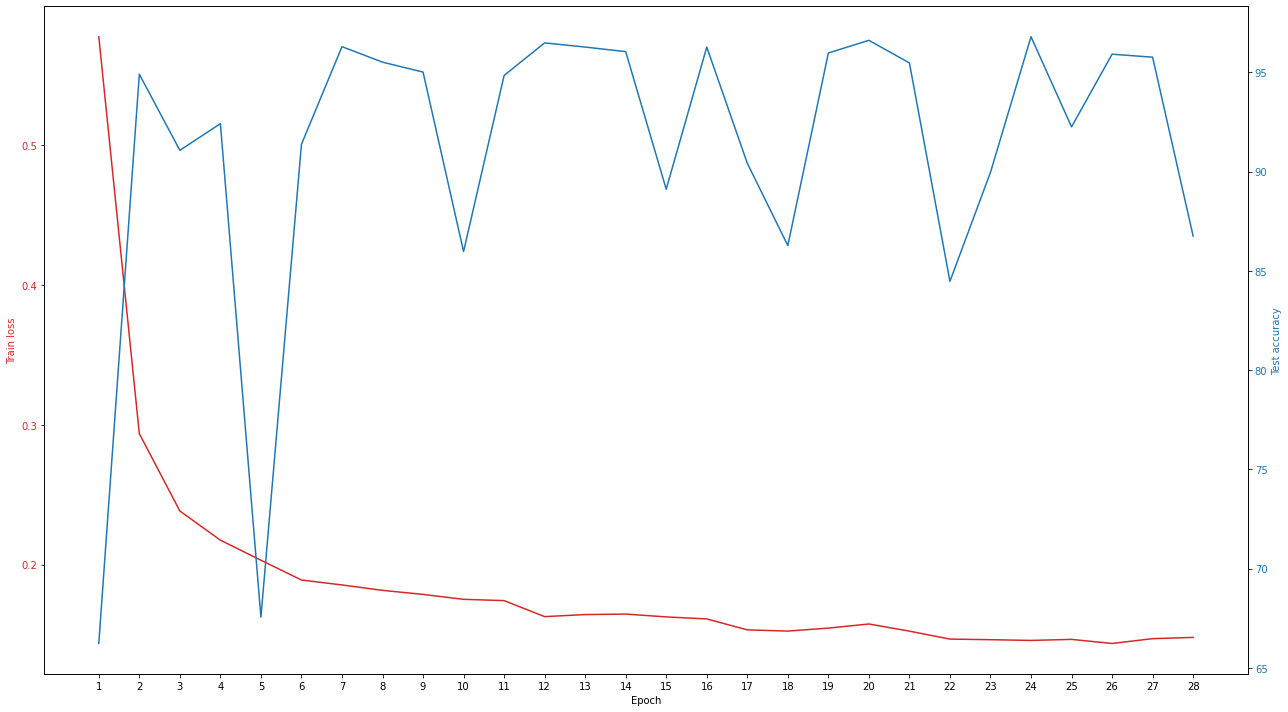

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_28.pth
Train Epoch: 29 [0/60000 (0%)]	Loss: 0.050888
Train Epoch: 29 [6400/60000 (11%)]	Loss: 0.176165
Train Epoch: 29 [12800/60000 (21%)]	Loss: 0.138743
Train Epoch: 29 [19200/60000 (32%)]	Loss: 0.152761
Train Epoch: 29 [25600/60000 (43%)]	Loss: 0.108105
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.036939
Train Epoch: 29 [38400/60000 (64%)]	Loss: 0.116209
Train Epoch: 29 [44800/60000 (75%)]	Loss: 0.142794
Train Epoch: 29 [51200/60000 (85%)]	Loss: 0.105216
Train Epoch: 29 [57600/60000 (96%)]	Loss: 0.055365

Test set: Average loss: 0.0001, Accuracy: 9658/10000 (97%)

[0.05088835582137108, 0.13363997638225555, 0.13806451857089996, 0.15574117004871368, 0.18122436106204987, 0.3286210298538208, 0.05992044880986214, 0.02963312715291977, 0.1294897198677063, 0.08840418606996536, 0.18042729794979095, 0.047354888170957565, 0.04939105734229088, 0.2613629400730133, 0.20676535367965698, 0.11851465702056885, 0.15006

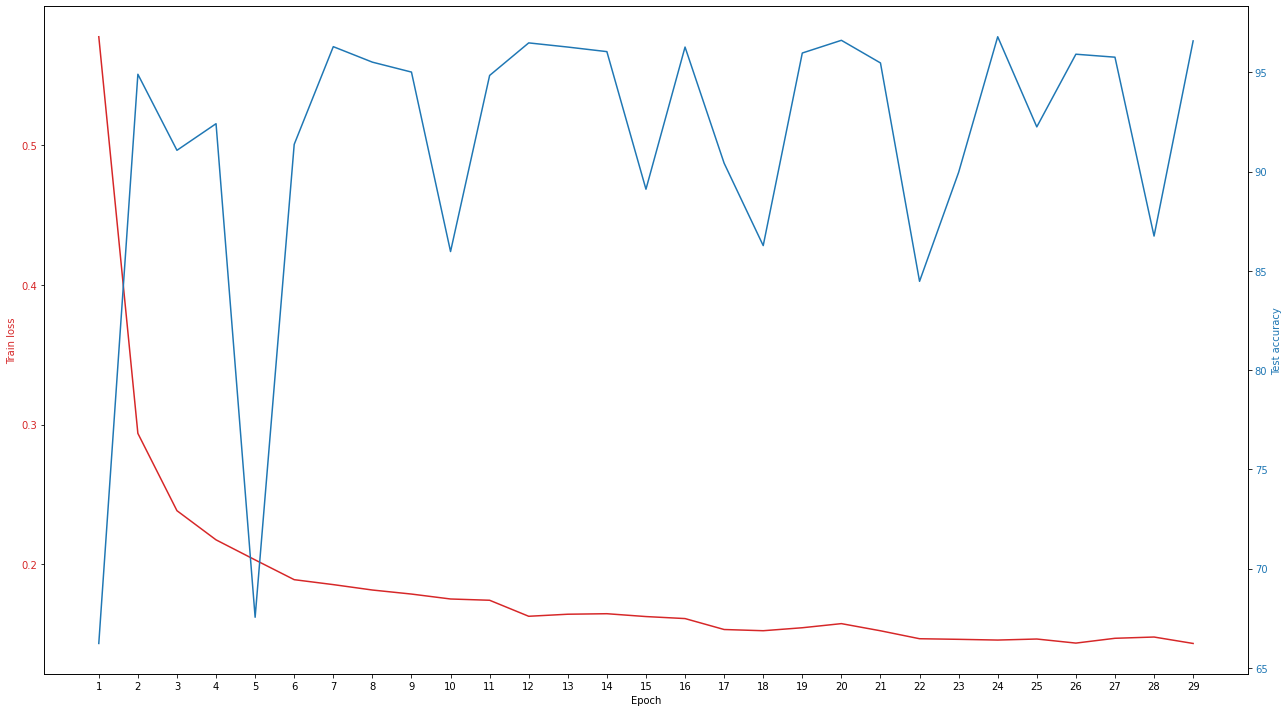

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_29.pth
Train Epoch: 30 [0/60000 (0%)]	Loss: 0.250840
Train Epoch: 30 [6400/60000 (11%)]	Loss: 0.102262
Train Epoch: 30 [12800/60000 (21%)]	Loss: 0.016136
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.086100
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.140279
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.227083
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.129972
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.148538
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.078155
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.052162

Test set: Average loss: 0.0001, Accuracy: 9527/10000 (95%)

[0.25084030628204346, 0.08384647965431213, 0.21431437134742737, 0.14580437541007996, 0.1552470624446869, 0.2928309142589569, 0.08240031450986862, 0.2876376807689667, 0.06533531844615936, 0.08340764790773392, 0.05908472463488579, 0.15044620633125305, 0.13217361271381378, 0.09898535907268524, 0.01956411637365818, 0.07964912801980972, 0.047957

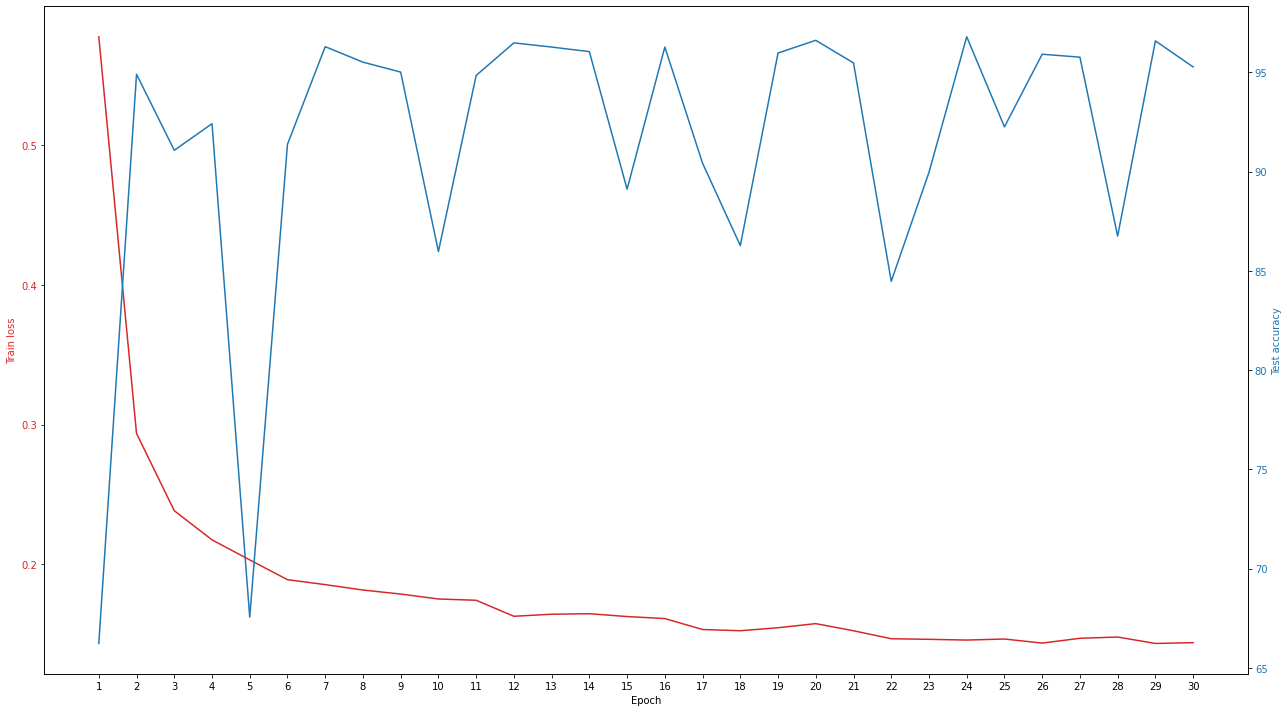

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_30.pth


In [49]:
test_accuracy_list = []
train_loss_list = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_accuracy = test()


    if epoch%40==0:
        optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

    x_axis = np.arange(1,epoch+1)
    test_accuracy_list.append(test_accuracy)
    train_loss_list.append(np.mean(train_loss))
    # plt.plot()
    print(train_loss)
    print(train_loss_list)
    
    fig, ax1 = plt.subplots()
    x_axis = np.arange(1,epoch+1,dtype=int)
    fig.set_size_inches(18,10)

    ax1.set_xticks(x_axis)
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train loss', color=color)
    ax1.plot(x_axis, train_loss_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Test accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_axis, test_accuracy_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    model_path = os.path.join(models_path,f"epoch_{epoch}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"saved model {model_path}")


In [50]:
best_epoch = np.argmax(test_accuracy_list)+1
best_epoch

24

In [51]:
model_path = os.path.join(models_path,f"epoch_{best_epoch}.pth")
model = Net()
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [52]:
model_path

'/shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/epoch_24.pth'

In [53]:
model_path = os.path.join(models_path,f"best.pth")
torch.save(model.state_dict(), model_path)
print(f"saved model {model_path}")

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_4/best.pth


In [54]:
# test()